> # **Proyecto Análisis Avanzado de Datos: Walmart Sales**
>
> * Ximena Rojas Castro
> * Julián Castro
> * Laura Sofia Rincón Sierra


# Retroalimentación 


Muy completo el análisis de series de tiempo, especialmente explorando esos modelos como el kernel y los ARIMA/SARIMA. Sin embargo, tengo algunos comentarios:

Validar y Comparar los Modelos: interesante que hayan usado diferentes modelos, pero toca fortalecer la parte de cómo los validaron y compararon. Sería muy útil que añadieran una parte donde muestren cómo cada modelo se la juega con los datos, usando métricas claras. Comparar los modelos también les ayudaría a entender mejor cuál funciona mejor.

Veo que trabajaron con varios sets de datos, pero quedé un poco enredado sobre por qué los analizaron por separado en kernel y no como una sola serie de tiempo. en sarima no em queda claro proque m es 26, cual es la muestra de datos , se ve que es anual la estacionalidad  

Les vendría bien una sección de conclusiones más completa. Ahí podrían resumir todo lo que encontraron, hablar de lo que significa todo esto y dar unas recomendaciones con base en los resultados.

## comentarios de los compañeros 

GRUPO B
Detallar con claridad la problemática a resolver, para justificar el planteamiento de los objetivos y soluciones.
En general, el proyecto está bien, sólo encontramos que no está muy claro la justificación del modelo de regresión. Por ejemplo, ¿bajo qué razón asumir que la variable "Date" es explicada por las demás variables?; ¿este modelo respeta la estacionalidad original de las ventas semanales?; etc.
Es sugerible agregar un poco mas de información sobre el desarrollo y porqué se hace cada cosa.
Excelente el archivo pdf explicando el EDA
Ninguna
Súper
Todo bien 



> Comenzamos importando las librerías necesarias para el desarrollo del proyecto

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import seaborn as sns

import math
from datetime import datetime
from datetime import timedelta

import itertools
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose as season
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA

import warnings
warnings.filterwarnings("ignore")

> Instalamos algunas dependencias para utilizar el API de Kaggle

In [ ]:
!pip install pmdarima

In [ ]:
from pmdarima.utils import decomposed_plot
from pmdarima.arima import decompose
from pmdarima import auto_arima

In [ ]:
!pip install -q kaggle

> **Importante:** Para las siguientes líneas es necesario tener el archivo .json de nuestro usuario de Kaggle (para más información de como descargarlo, puedes consultar el siguiente link: [Kaggle API](https://github.com/Kaggle/kaggle-api)). Este archivo nos permite conectarnos con nuestras credenciales a la API.

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d aslanahmedov/walmart-sales-forecast

  0% 0.00/3.36M [00:00<?, ?B/s]
100% 3.36M/3.36M [00:00<00:00, 139MB/s]


In [ ]:
!unzip walmart-sales-forecast.zip

Archive:  walmart-sales-forecast.zip
  inflating: features.csv            
  inflating: stores.csv              
  inflating: test.csv                
  inflating: train.csv               


> Guardamos los datasets en distintas variables


In [ ]:
df_store = pd.read_csv('stores.csv') #store data
df_store.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [ ]:
df_train = pd.read_csv('train.csv') #store data
df_train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [ ]:
df_features = pd.read_csv('features.csv')
df_features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


> Almacenamos la información de los datasets en uno solo

In [ ]:
df = df_train.merge(df_features, on=['Store', 'Date'], how='inner').merge(df_store, on=['Store'], how='inner')
df.head(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315


> Eliminamos la columna repetida y renombramos

In [ ]:
df.drop(['IsHoliday_y'], axis=1,inplace=True) # Eliminamos
df.rename(columns={'IsHoliday_x':'IsHoliday'},inplace=True) # Renonmbramos
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315


> ## **Analisis Exploratorio**
>
> En primer lugar se realizó un análisis exploratorio, ya que este permite tener una comprensión profunda de la estructura y las características de los conjuntos de datos seleccionados. Así, es posible determinar tendencias, anomalías o *insights* preliminares que guían el proceso de modelado.

> **Datos faltantes**
>
> Comenzaremos revisando la cantidad de datos faltantes para las variables de nuestro conjunto de datos

In [ ]:
df.isnull().sum()

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
Type                 0
Size                 0
dtype: int64

> Primero, eliminaremos las columnas de MarkDown1 a MarkDown5, ya que presentan datos faltantes para todas las observaciones

In [ ]:
df.drop(['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5'], axis=1,inplace=True) # Eliminamos MarkDown
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,211.096358,8.106,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,211.096358,8.106,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,211.096358,8.106,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,211.096358,8.106,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,211.096358,8.106,A,151315


> **Exploración descriptiva**
>
> Ahora, observamos algunas estadísticas descriptivas básicas como la media, la mediana, la desviación estándar y los percentiles. Esto nos da una idea de la estructura de los datos.

In [ ]:
df.describe()

,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,Size
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123,60.090059,3.361027,171.201947,7.960289,136727.915739
std,12.785297,30.492054,22711.183519,18.447931,0.458515,39.159276,1.863296,60980.583328
min,1.000000,1.000000,-4988.940000,-2.060000,2.472000,126.064000,3.879000,34875.000000
25%,11.000000,18.000000,2079.650000,46.680000,2.933000,132.022667,6.891000,93638.000000
50%,22.000000,37.000000,7612.030000,62.090000,3.452000,182.318780,7.866000,140167.000000
75%,33.000000,74.000000,20205.852500,74.280000,3.738000,212.416993,8.572000,202505.000000
max,45.000000,99.000000,693099.360000,100.140000,4.468000,227.232807,14.313000,219622.000000


> **Correlación entre los datos**
>
> Utilizamos la matriz de correlación para entender las relaciones entre variables en el conjunto de datos. Esta matriz cuantifica las asociaciones lineales, permitiendo identificar patrones, seleccionar variables relevantes y proporcionar información crucial para la construcción y evaluación de modelos estadísticos, como la regresión.

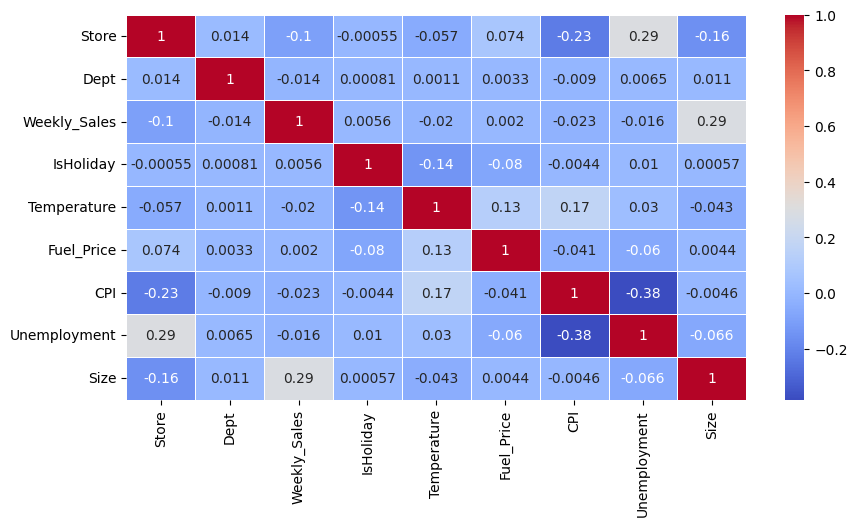

In [ ]:
correlation_matrix = df.corr(method='spearman')

fig = plt.figure(figsize = (10,5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.show()

> **Relaciones no lineales de los datos**
>
> Utilizamos un scatterplot para visualizar la variable objetivo en términos de las demás (no cualitatibas) del dataset, ya que este tipo de gráfica es eficaz para detectar relaciones curvilíneas, no monótonas o asimétricas entre las variables, proporcionando una visión visualmente intuitiva de la complejidad de las asociaciones en los datos.

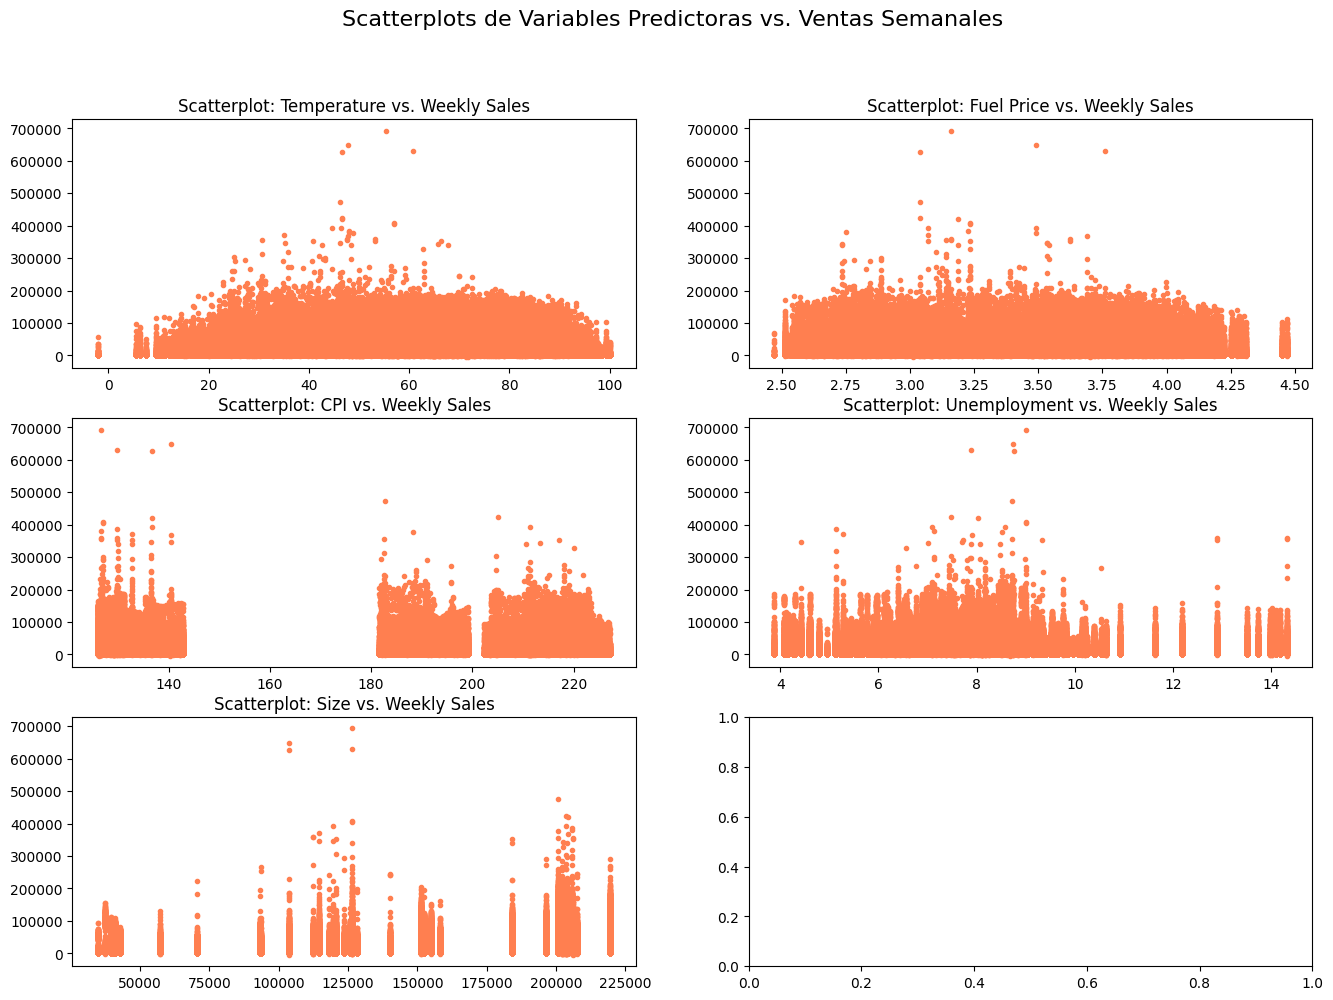

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(16, 11))

ax[0, 0].scatter(df['Temperature'], df['Weekly_Sales'], color='coral', marker='.')
ax[0, 0].set_title('Scatterplot: Temperature vs. Weekly Sales')

ax[0, 1].scatter(df['Fuel_Price'], df['Weekly_Sales'], color='coral', marker='.')
ax[0, 1].set_title('Scatterplot: Fuel Price vs. Weekly Sales')

ax[1, 0].scatter(df['CPI'], df['Weekly_Sales'], color='coral', marker='.')
ax[1, 0].set_title('Scatterplot: CPI vs. Weekly Sales')

ax[1, 1].scatter(df['Unemployment'], df['Weekly_Sales'], color='coral', marker='.')
ax[1, 1].set_title('Scatterplot: Unemployment vs. Weekly Sales')

ax[2, 0].scatter(df['Size'], df['Weekly_Sales'], color='coral', marker='.')
ax[2, 0].set_title('Scatterplot: Size vs. Weekly Sales')

fig.suptitle('Scatterplots de Variables Predictoras vs. Ventas Semanales', fontsize=16)

plt.show()

> De acuerdo con la distribución de los datos, se pueden identificar patrones no lineales (tal vez polinómicos) para algunas variables. Para esto, puede ser bueno un enfoque de suavizado o regresión.

> **Ventas por mes**
>
> Observamos la ventas por mes para identificar patrones temporales y entender la variabilidad a lo largo del tiempo. Este tipo de visualización proporciona una perspectiva clara de las tendencias estacionales, fluctuaciones mensuales y posibles patrones cíclicos en las ventas. Al observar cómo las ventas evolucionan a lo largo de los meses, se pueden descubrir comportamientos estacionales, como picos durante las temporadas festivas o disminuciones en ciertos meses.

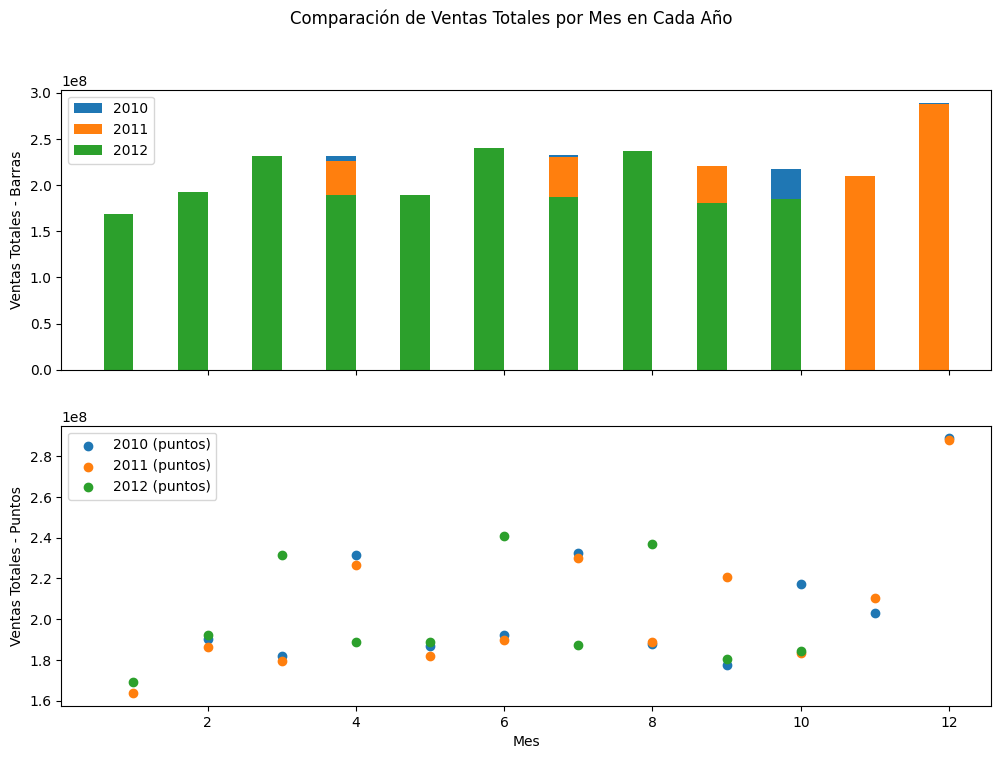

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])

df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

ventas_por_mes = df.groupby(['Year', 'Month'])['Weekly_Sales'].sum().reset_index()

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12, 8), sharex=True)

for year in ventas_por_mes['Year'].unique():
    datos_por_año = ventas_por_mes[ventas_por_mes['Year'] == year]
    ax1.bar(datos_por_año['Month'] - 0.2, datos_por_año['Weekly_Sales'], width=0.4, label=str(year))

ax1.set_ylabel('Ventas Totales - Barras')
ax1.legend()

for year in ventas_por_mes['Year'].unique():
    datos_por_año = ventas_por_mes[ventas_por_mes['Year'] == year]
    ax2.scatter(datos_por_año['Month'], datos_por_año['Weekly_Sales'], label=f"{year} (puntos)", marker='o')

ax2.set_xlabel('Mes')
ax2.set_ylabel('Ventas Totales - Puntos')
ax2.legend()

fig.suptitle('Comparación de Ventas Totales por Mes en Cada Año')

plt.show()

> **Comparación de ventas promedio por semana**
>
> Adicionalmente, visualizamos las ventas promedio por semana ya que esto proporciona una perspectiva detallada de la dinámica semanal, lo que facilita la formulación de estrategias adaptadas a los patrones específicos de consumo a lo largo del tiempo.

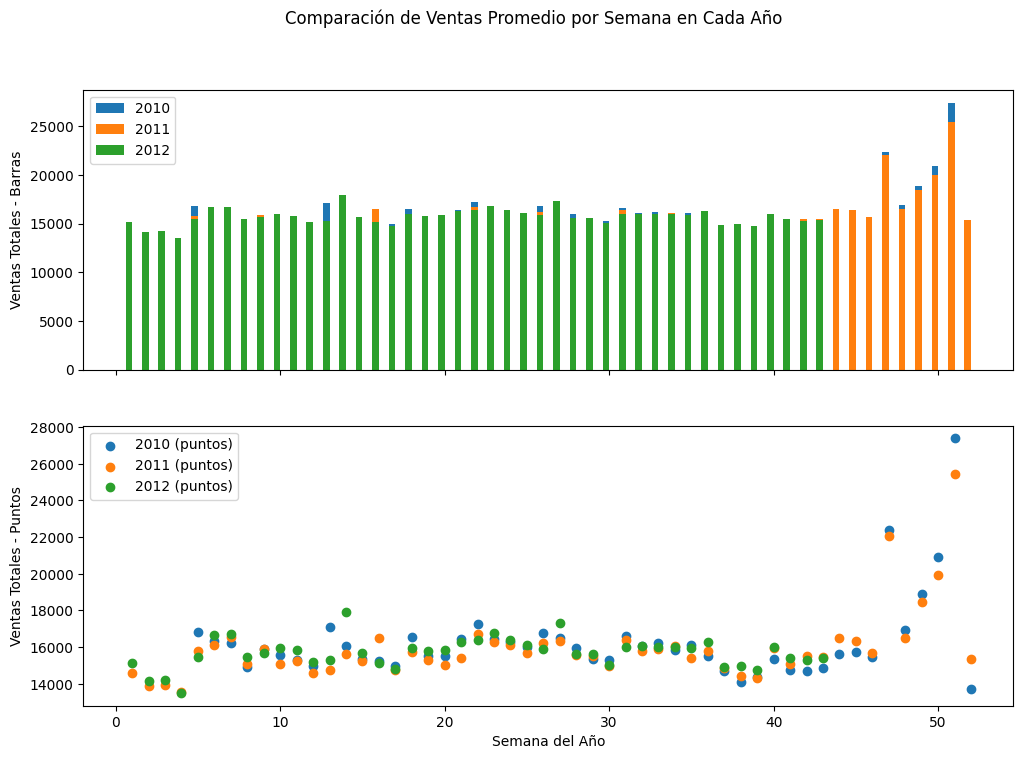

In [ ]:
df['Year'] = df['Date'].dt.year
df['Week'] = df['Date'].dt.isocalendar().week

ventas_por_semana = df.groupby(['Year', 'Week'])['Weekly_Sales'].mean().reset_index()

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12, 8), sharex=True)

for year in ventas_por_semana['Year'].unique():
    datos_por_año = ventas_por_semana[ventas_por_semana['Year'] == year]
    ax1.bar(datos_por_año['Week'] - 0.2, datos_por_año['Weekly_Sales'], width=0.4, label=str(year))

ax1.set_ylabel('Ventas Totales - Barras')
ax1.legend()

for year in ventas_por_semana['Year'].unique():
    datos_por_año = ventas_por_semana[ventas_por_semana['Year'] == year]
    ax2.scatter(datos_por_año['Week'], datos_por_año['Weekly_Sales'], label=f"{year} (puntos)", marker='o')

ax2.set_xlabel('Semana del Año')
ax2.set_ylabel('Ventas Totales - Puntos')
ax2.legend()

fig.suptitle('Comparación de Ventas Promedio por Semana en Cada Año')

plt.show()

> **Ventas semanales por tienda y departamento**
>
> Vamos a graficar las ventas semanales por tienda y realizar comparaciones entre ellas es esencial para obtener una visión detallada de la contribución individual de cada establecimiento al rendimiento general.

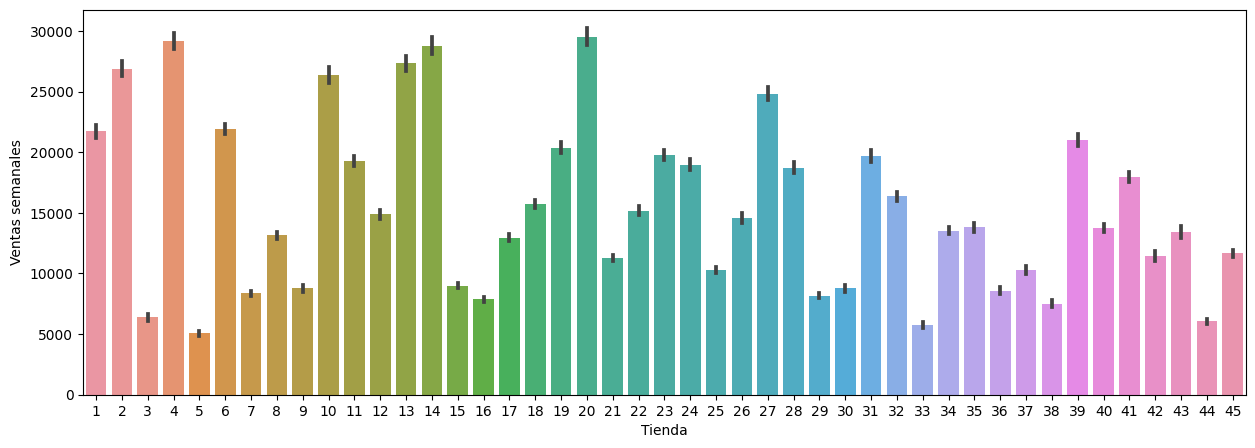

In [ ]:
plt.figure(figsize=(15, 5))
fig = sns.barplot(x='Store', y='Weekly_Sales', data=df)
fig.set(xlabel="Tienda", ylabel="Ventas semanales")
plt.show()

>  De la misma forma, realizaremos la gráfica de ventas por departamento.

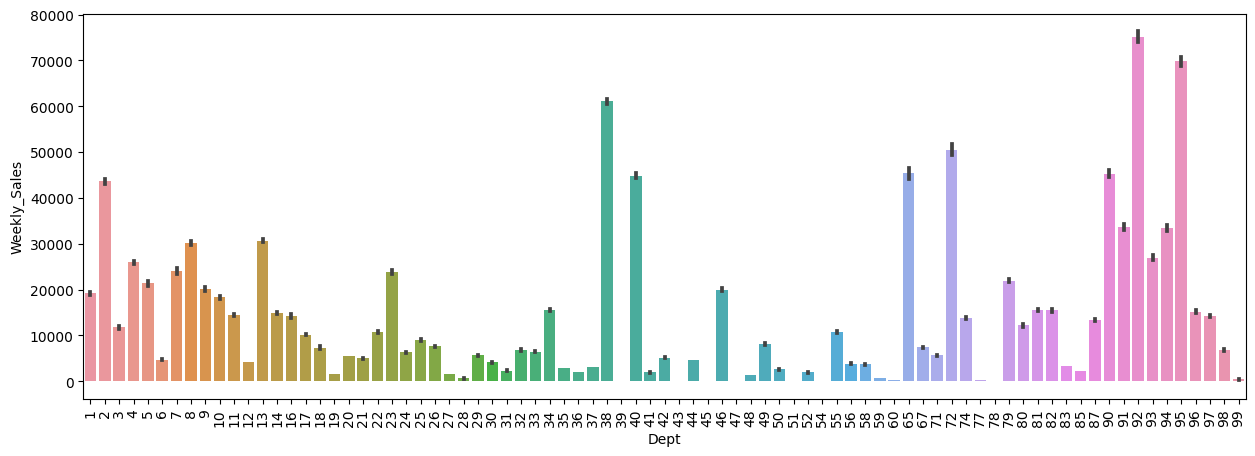

In [ ]:
plt.figure(figsize=(15, 5))
fig = sns.barplot(x='Dept', y='Weekly_Sales', data=df)
plt.xticks(rotation=90)
plt.show()

> **Ventas semanales por departamento y por tienda**
>
> Con el fin de ver más a detalle la contribución de cada tienda a las ventas, graficaremos de forma individual las ventas por tienda en cada departamento.

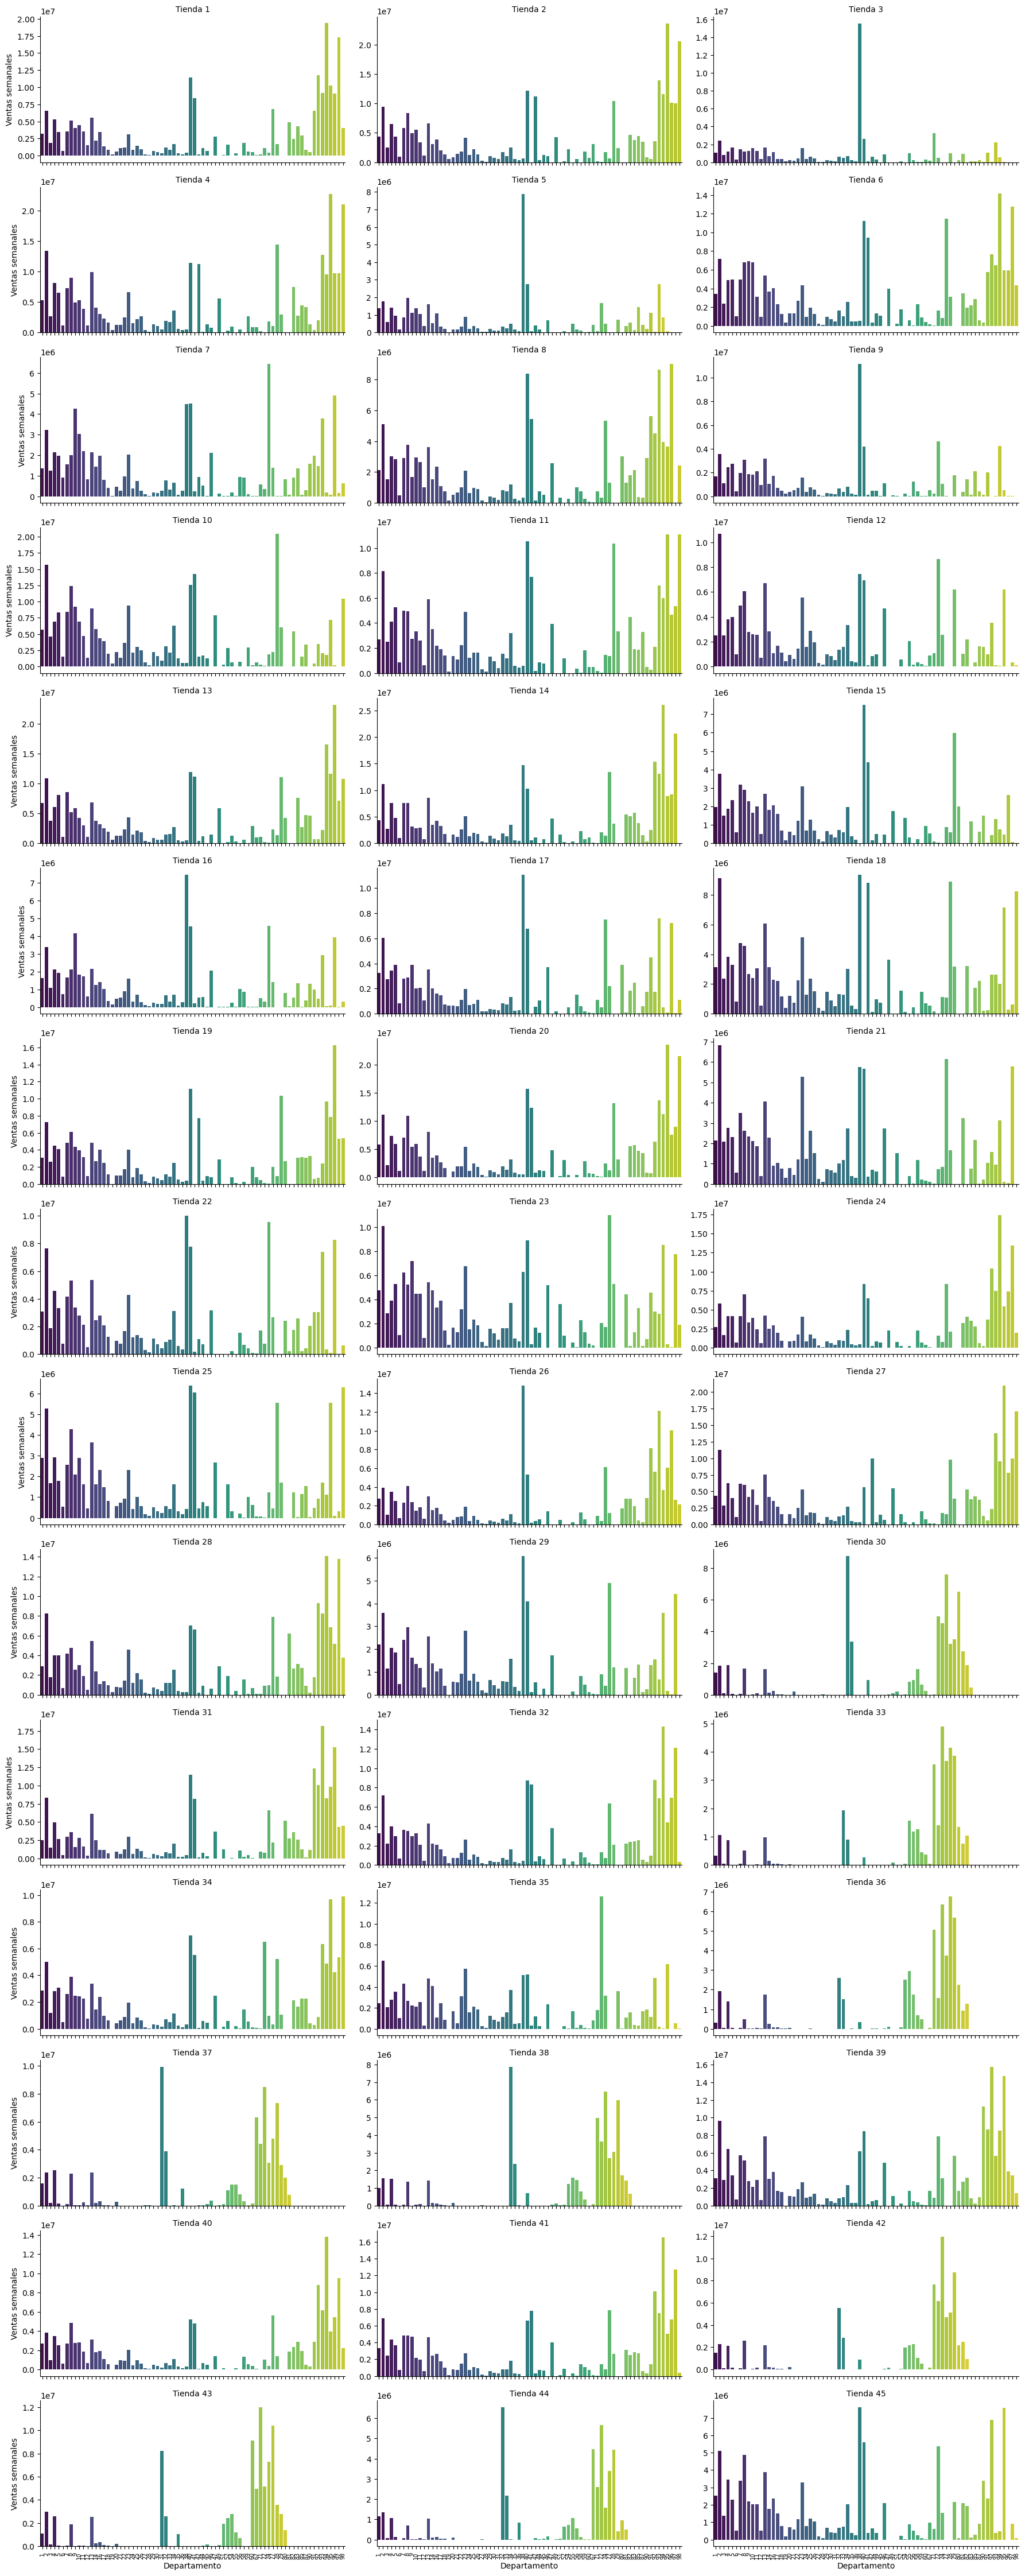

In [ ]:
resultados = df.groupby(['Store', 'Dept']).agg({'Weekly_Sales': 'sum'}).reset_index()

g = sns.FacetGrid(resultados, col="Store", col_wrap=3, sharey=False, height=3, aspect=2)
g.map(sns.barplot, "Dept", "Weekly_Sales", palette="viridis")
for ax in g.axes.flat:
  for label in ax.get_xticklabels():
    label.set_rotation(90)
    label.set_fontsize(7)
g.set_axis_labels("Departamento", "Ventas semanales")
g.set_titles("Tienda {col_name}")
plt.show()

> Podemos observar que en las graficas anteriores hay tiendas que tienen ventas por debajo de 0, esto no es posible por lo que vamos ver cual es el porcentaje de estos datos y de no ser significativo podremos a eliminar estos datos.

In [ ]:
df_n = df.loc[df['Weekly_Sales'] <= 0]

n = df_n.shape
d = df.shape

print(f'El porcentaje de tiendas con departamentos que tienen ventas negativas es {(n[0]/d[0])*100}%')

El porcentaje de tiendas con departamentos que tienen ventas negativas es 0.3221291837654482%


> Tomamos solo los datos mayores a cero

In [ ]:
df = df.loc[df['Weekly_Sales'] > 0]

> **Ventas semanales en días festivos**
>
> Este análisis es esencial para entender el impacto estacional de días festivos en las ventas de una tienda. Al comparar las tendencias de ventas en períodos festivos y no festivos, se pueden identificar patrones significativos, como picos de demanda durante celebraciones específicas.

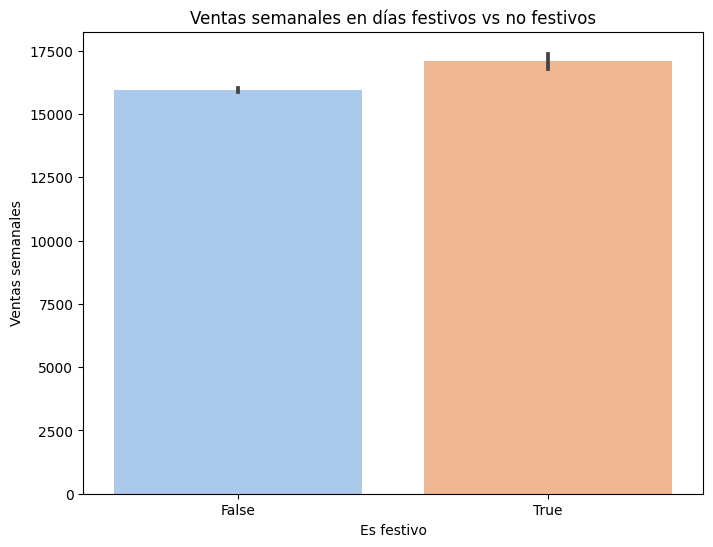

In [ ]:
colors = sns.color_palette("pastel")

# Crear la gráfica de barras
plt.figure(figsize=(8, 6))
sns.barplot(x='IsHoliday', y='Weekly_Sales', data=df, palette=colors)

plt.title('Ventas semanales en días festivos vs no festivos')
plt.xlabel('Es festivo')
plt.ylabel('Ventas semanales')

sns.set(style="whitegrid")

plt.show()

> **Series de tiempo**
>
> Estos gráficos permiten visualizar cómo las ventas evolucionan a lo largo del tiempo, identificar patrones recurrentes a nivel semanal, y evaluar la magnitud de los residuos, lo que puede ser crucial para entender y modelar eficazmente la serie temporal de ventas. La descomposición de la serie temporal es una herramienta poderosa para extraer información significativa y facilitar la toma de decisiones basada en el comportamiento histórico de las ventas.

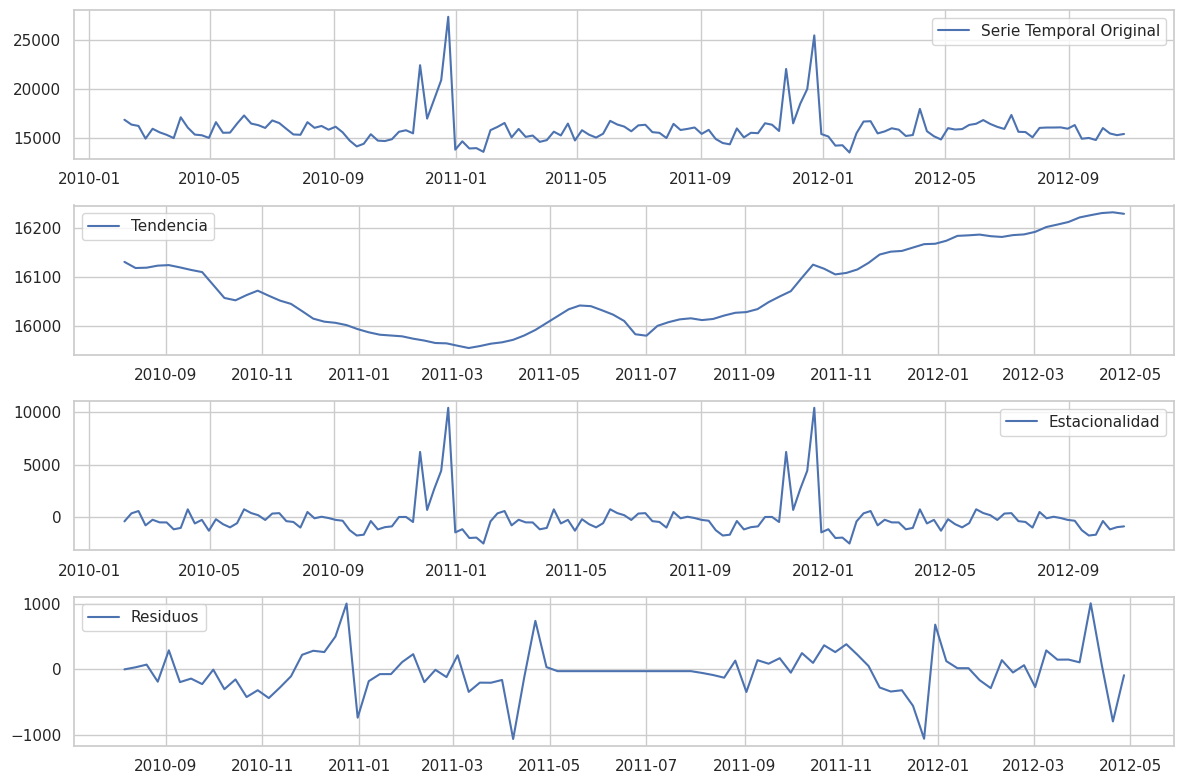

In [ ]:
ventas_por_dia = df.groupby('Date')['Weekly_Sales'].mean().reset_index()

serie_temporal = pd.Series(ventas_por_dia['Weekly_Sales'].values, index=ventas_por_dia['Date'])

descomposicion = seasonal_decompose(serie_temporal, model='additive', period=52)  # Usamos period=52 para indicar la estacionalidad semanal

plt.figure(figsize=(12, 8))

# Serie original
plt.subplot(411)
plt.plot(serie_temporal, label='Serie Temporal Original')
plt.legend()

# Tendencia
plt.subplot(412)
plt.plot(descomposicion.trend, label='Tendencia')
plt.legend()

# Estacionalidad
plt.subplot(413)
plt.plot(descomposicion.seasonal, label='Estacionalidad')
plt.legend()

# Residuos
plt.subplot(414)
plt.plot(descomposicion.resid, label='Residuos')
plt.legend()

plt.tight_layout()
plt.show()

> ## **Análisis y resultados**
>
> A continuación, abarcaremos la implementación de diversas técnicas de modelado con el objetivo de profundizar en la comprensión de los datos. Al emplear estas herramientas analíticas, buscamos capturar y explotar patrones subyacentes, relaciones y complejidades en el conjunto de datos.

> ### **Modelado con regresión Kernel**
>
>  Las técnicas de suavizado son herramientas esenciales en el análisis de datos para reducir el ruido y la variabilidad, haciendo que los patrones subyacentes sean más visibles. El suavizado es crucial en la construcción de modelos predictivos precisos, al mejorar la capacidad de generalización del modelo a nuevos datos y al proporcionar una representación más clara de la estructura de los datos.
>
> En este caso, utilizaremos el modelado con kernel para realizar un **análisis bivariado**, que nos permita establecer relaciones entre las variables independientes y las ventas, para así identificar tendencias, patrones, puntos de interés, sensibilidad a cambios, etc.

In [ ]:
X = df.drop(['Weekly_Sales'], axis=1)
y = df['Weekly_Sales']

> Vamos a realizar un muestreo de datos para hacer validación cruzada con un conjunto más pequeño y encontrar el mejor hiperparámetro lambda. El tamaño de la muestra es muy pequeño para disminuir el tiempo de ejecución.

In [ ]:
X_train_sample, _, y_train_sample, _ = train_test_split(X, y, test_size=0.99, random_state=42)

> Creamos una función para realizar validación cruzada

In [ ]:
''' Input: Kernel: Función de Kernel a utilizar
           X_matrix: Datos de entrada al modelo
           Variable: variable a utilizar
           y: Variable objetivo
           gamma_list: Lista de hiperparámetros
           cv: Cantidad de iteraciones en cross validation
    Output: Mejor hiperparámetro gamma para el modelo
'''

def cross_val_kernel_smoothing(kernel, X_matrix, variable, y, gamma_list, cv=5):

  X = X_matrix[variable]

  X = np.array(X, dtype=float).reshape(-1, 1).ravel()
  y = np.array(y, dtype=float).reshape(-1, 1)

  n = len(X)
  fold_size = int(n/cv)
  scores_mse = []
  scores_r2 = []

  mean_scores = {}

  for gamma in gamma_list:
    for i in range(cv):

      start = i * fold_size
      end = (i + 1) * fold_size

      X_set = X[start:end]
      y_set = y[start:end]
      sort_index = np.argsort(X_set)
      X_set = X_set[sort_index]
      y_set_sorted = y_set[sort_index]
      x_smooth = np.linspace(min(X_set), max(X_set), len(y_set))
      y_knn_weighted = np.array([kernel(gamma, x, X_set, y_set)
                                  for x in x_smooth])

      mean_y_set = np.nanmean(y_knn_weighted)
      y_knn_weighted = np.nan_to_num(y_knn_weighted, nan=mean_y_set)

      mse = mean_squared_error(y_set, y_knn_weighted)
      r2 = r2_score(y_set, y_knn_weighted)
      scores_mse.append(mse)
      scores_r2.append(r2)

    mean_scores[gamma] = (np.mean(scores_mse), np.mean(scores_r2))

  min_gamma = sorted(mean_scores.items(), key = lambda item: item[1])[0][0]

  print(f'El mejor hiperparámetro es gamma = {min_gamma}')
  print(f'con un MSE = {mean_scores[min_gamma][0]}')
  print(f'con un R^2 = {mean_scores[min_gamma][1]}\n')

  # Implementamos el mejor resultado

  x_smooth = np.linspace(min(X), max(X), 1000)
  y_knn_weighted = np.array([kernel(min_gamma, x, X, y)
                                  for x in x_smooth])

  # Graficamos la mejor solución
  fig, axs  = plt.subplots(1,2,figsize=(14, 5))
  axs[0].scatter(X, y, label='Datos originales')
  axs[0].plot(x_smooth, y_knn_weighted, label='Suavizado de núcleo', color='C2')
  axs[1].plot(x_smooth, y_knn_weighted, label='Suavizado de núcleo', color='C2')
  axs[0].legend()
  axs[0].set_title(f'{variable} vs. Weekly_Sales')
  axs[1].legend()
  axs[1].set_title(f'Suavizado para la variable {variable}')
  plt.xlabel('X')
  plt.ylabel('Y')
  plt.show()

> **Kernel de Epanechnikov**
>
> Este kernel permite ajustar una curva cuando no se tiene relaciones lineales y no requiere ninguna suposición previa sobre la distribución de los datos (es robusto en ese sentido). Se define de la siguiente forma:

$$
K(x,x_0) =
\begin{cases}
\frac{3}{4}(1 - \left(\frac{|x-x_0|}{\lambda}\right)^2) &
\text{si } \frac{|x-x_0|}{\lambda} \leq 1 \\
0 &
\text{si } \frac{|x-x_0|}{\lambda} > 1
\end{cases}
$$

In [ ]:
def knn_Epanechnikov(lmbda:float, point:float,
                 data_x:np.ndarray, data_y:np.ndarray) -> float:
    # Calculo de la distancia Normalizada
    t = np.absolute(data_x-point)/lmbda
    #aplicacion del kernel Epanechnikov
    k = np.where(t <= 1, .75*(1-t), 0)
    # se retorna el promedio ponderado
    return (k @ data_y).sum()/k.sum()

> Implementamos el suavizado para todas las variables

El mejor hiperparámetro es gamma = 1.0
con un MSE = 691678867.0983801
con un R^2 = -0.30525409769492745



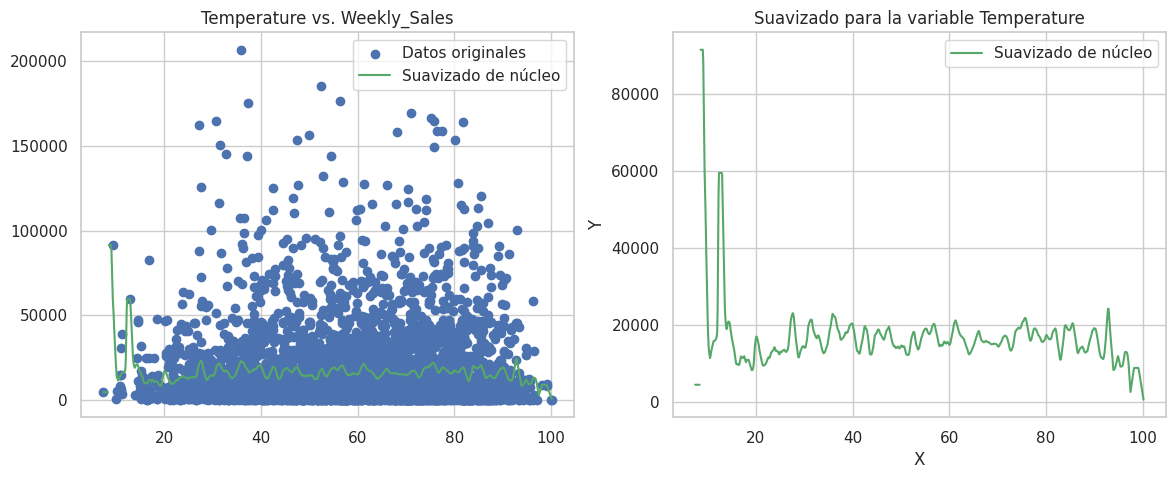

In [ ]:
hiper_list = np.linspace(0.1,1,100)
cross_val_kernel_smoothing(knn_Epanechnikov, X_train_sample, 'Temperature', y_train_sample, hiper_list, 10)

El mejor hiperparámetro es gamma = 1.0
con un MSE = 530965353.06521654
con un R^2 = 0.0011736029709604253



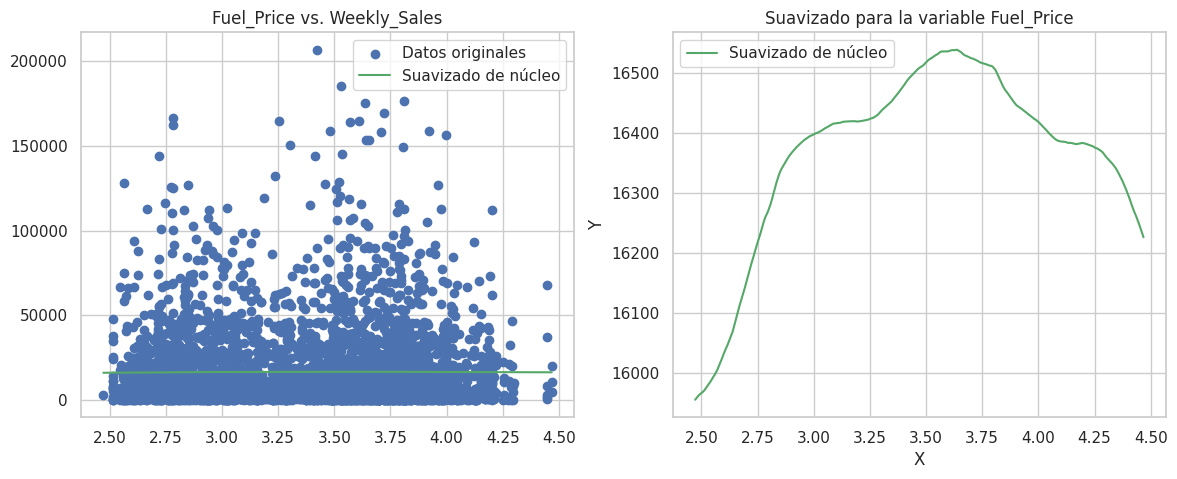

In [ ]:
hiper_list = np.linspace(0.1,1,100)
cross_val_kernel_smoothing(knn_Epanechnikov, X_train_sample, 'Fuel_Price', y_train_sample, hiper_list, 10)

El mejor hiperparámetro es gamma = 1.0
con un MSE = 629881150.5454367
con un R^2 = -0.18625394819288357



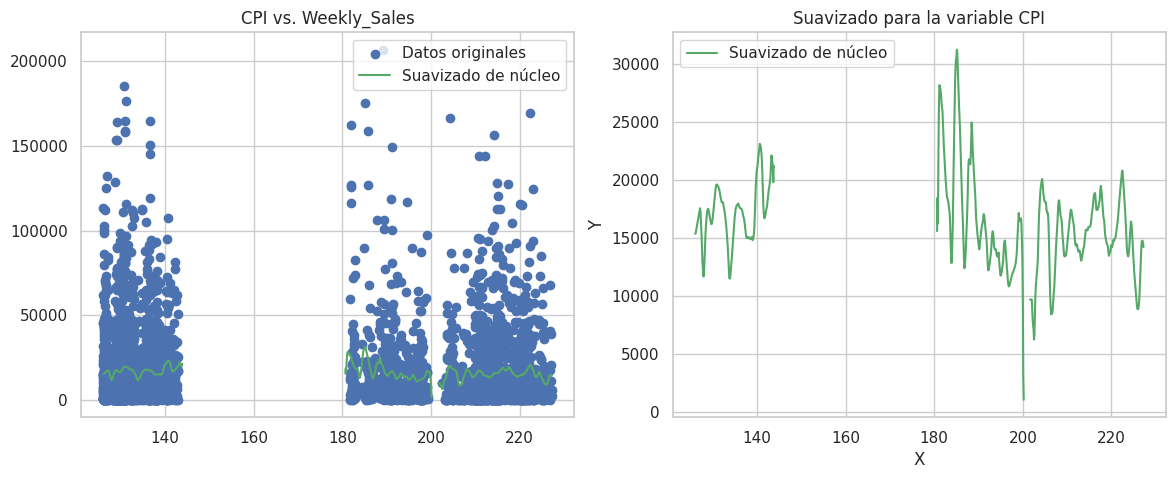

In [ ]:
hiper_list = np.linspace(0.1,1,100)
cross_val_kernel_smoothing(knn_Epanechnikov, X_train_sample, 'CPI', y_train_sample, hiper_list, 10)

El mejor hiperparámetro es gamma = 1.0
con un MSE = 582984294.0122367
con un R^2 = -0.09723168133391889



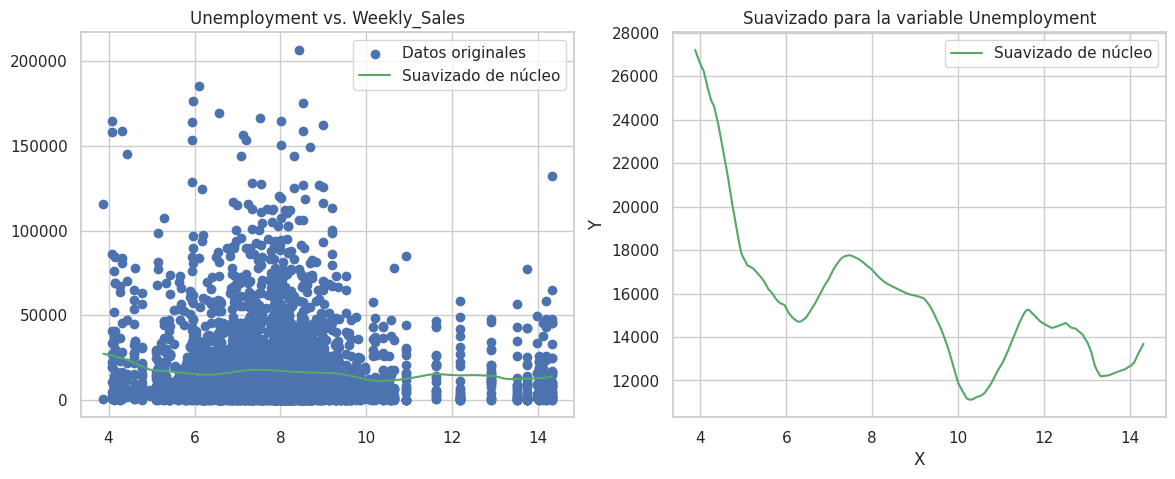

In [ ]:
hiper_list = np.linspace(0.1,1,100)
cross_val_kernel_smoothing(knn_Epanechnikov, X_train_sample, 'Unemployment', y_train_sample, hiper_list, 10)

El mejor hiperparámetro es gamma = 0.1272727272727273
con un MSE = 583174839.7456853
con un R^2 = -0.09680231490501283



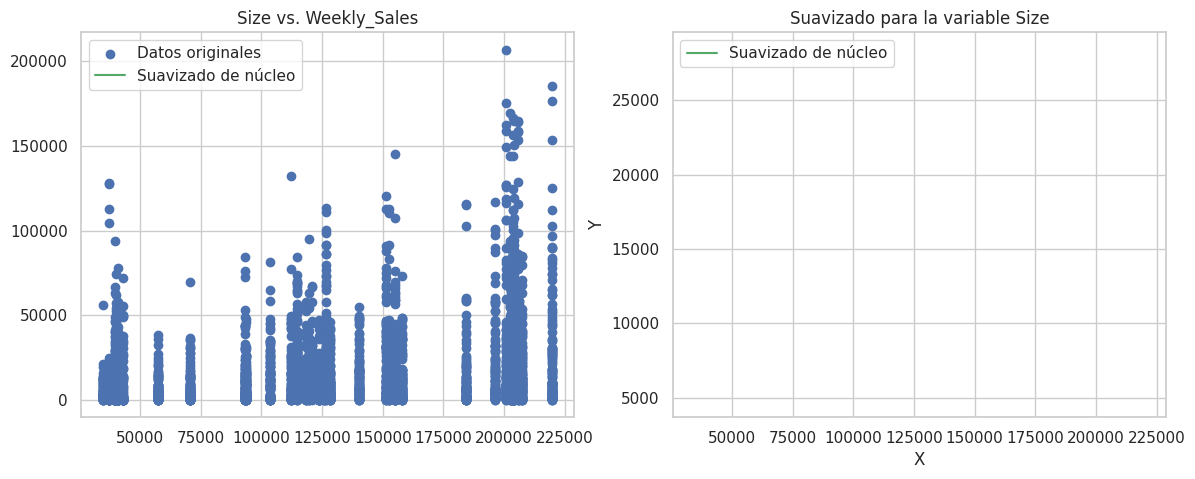

In [ ]:
hiper_list = np.linspace(0.1,1,100)
cross_val_kernel_smoothing(knn_Epanechnikov, X_train_sample, 'Size', y_train_sample, hiper_list, 10)

> Ahora, utilizaremos el mejor hiperparámetro para modelar sobre todos los datos

In [ ]:
temperature_values = np.linspace(min(X['Temperature']), max(X['Temperature']), num=1000)
temperature_estimates = [knn_Epanechnikov(1, temperature_val, X['Temperature'], y)
                         for temperature_val in temperature_values]

fuel_price_values = np.linspace(min(X['Fuel_Price']), max(X['Fuel_Price']), num=1000)
fuel_price_estimates = [knn_Epanechnikov(0.63, fuel_price_val, X['Fuel_Price'], y)
                        for fuel_price_val in fuel_price_values]

cpi_values = np.linspace(min(X['CPI']), max(X['CPI']), num=1000)
cpi_estimates = [knn_Epanechnikov(1, cpi_val, X['CPI'], y)
                  for cpi_val in cpi_values]

unemployment_values = np.linspace(min(X['Unemployment']), max(X['Unemployment']), num=1000)
unemployment_estimates = [knn_Epanechnikov(1, unemployment_val, X['Unemployment'], y)
                           for unemployment_val in unemployment_values]

size_values = np.linspace(min(X['Size']), max(X['Size']), num=1000)
size_estimates = [knn_Epanechnikov(0.55, size_val, X['Size'], y)
                  for size_val in size_values]

> Graficamos

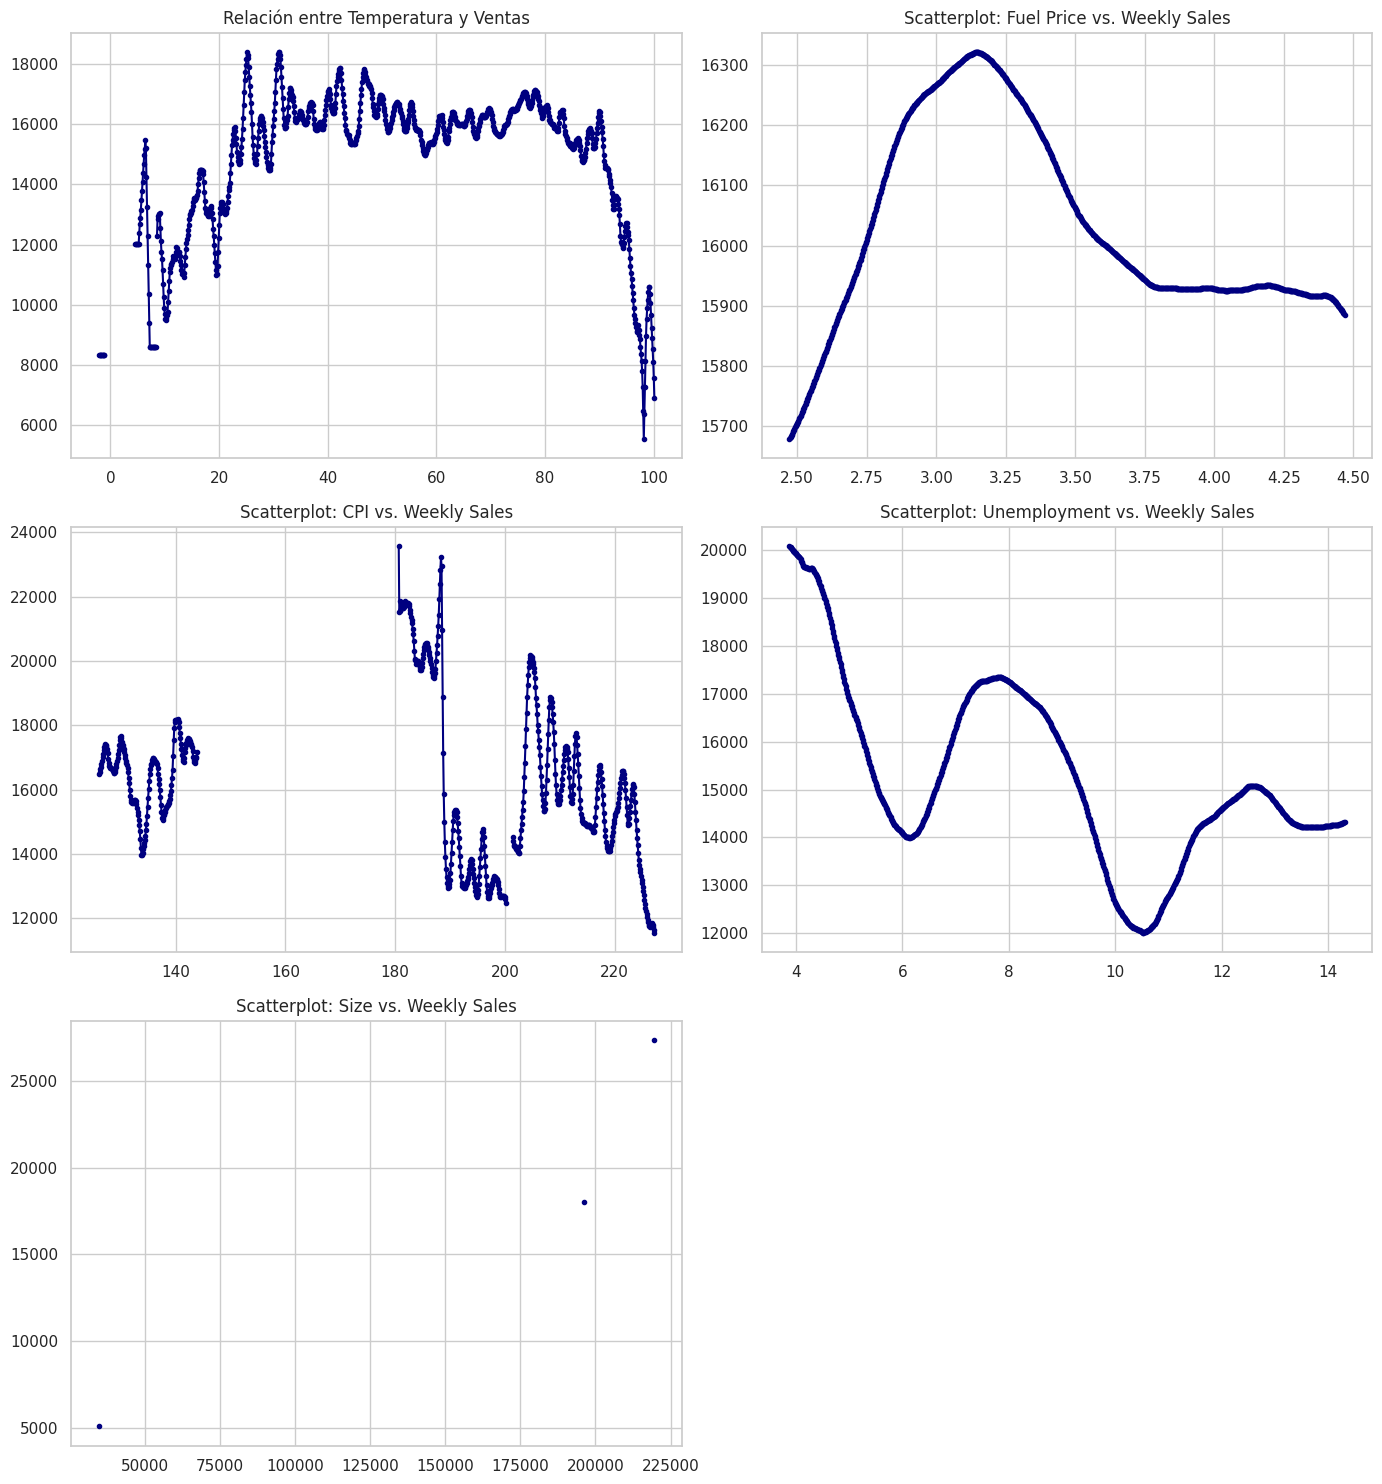

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(14, 15))

ax[0, 0].plot(temperature_values, temperature_estimates, color='navy', marker='.')
ax[0, 0].set_title('Relación entre Temperatura y Ventas')

ax[0, 1].plot(fuel_price_values, fuel_price_estimates, color='navy', marker='.')
ax[0, 1].set_title('Scatterplot: Fuel Price vs. Weekly Sales')

ax[1, 0].plot(cpi_values, cpi_estimates, color='navy', marker='.')
ax[1, 0].set_title('Scatterplot: CPI vs. Weekly Sales')

ax[1, 1].plot(unemployment_values, unemployment_estimates, color='navy', marker='.')
ax[1, 1].set_title('Scatterplot: Unemployment vs. Weekly Sales')

ax[2, 0].plot(size_values, size_estimates, color='navy', marker='.')
ax[2, 0].set_title('Scatterplot: Size vs. Weekly Sales')

ax[2, 1].axis('off')

plt.tight_layout()

plt.show()

> De este análisis se pueden concluir dos relaciones claras:
> * La tasa de desempleo aparenta tener una fuerte relación senoidal con las ventas, que van disminuyendo a medida que aumenta el desempleo. Esto puede deberse a una gran variedad de razones relacionadas con el poder adquisitivo, efectos económicos en las regiones, etc.
> * La temperatura en sus extremos (muy frío o muy caliente) parece influir en las ventas, generando una disminución de las mismas. Existen diversas razones que puedan estar influyendo en esta situación, desde patrones comportamentales de los clientes en las distintas épocas del año hasta la disminución en adquisición de productos que no son de temporada.

> ### **Regresión**
>
> El objetivo principal de este análisis fue desarrollar y evaluar un modelo de regresión polinómica para predecir las ventas semanales de las tiendas, considerando diversas variables predictoras como 'Store', 'Size', 'CPI', 'Temperature' y 'Fuel\_Price'. En el preprocesamiento de los datos, se agruparon por 'Store' y 'Date', sumando las ventas por departamento para obtener las ventas totales por tienda por semana. La columna 'Date' se eliminó, ya que se supone que la información ya está capturada en otras variables.

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])

> Agrupamos por tienda y fecha y sumamos las ventas

In [ ]:
# Agrupar por 'Store', 'Date' y sumar las ventas
df_ventas_tienda_semana = df.groupby(['Store', 'Date','Size','CPI','Temperature','Fuel_Price'])['Weekly_Sales'].sum().reset_index()

df_ventas_tienda_semana = df_ventas_tienda_semana.drop('Date', axis=1)

> Dividimos en conjunto de entrenamiento y test

In [ ]:
df_train = df_ventas_tienda_semana.copy()

target = 'Weekly_Sales'

m=[]
for i in df_train.columns.values:
    m.append(i.replace(' ','_'))

df_train.columns = m
X = df_train.drop([target],axis=1)
Y = df_train[target]
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=100)
Train_X.reset_index(drop=True,inplace=True)

print('Conjunto Original  ---> ',X.shape,Y.shape,'\nConjunto de entrenamiento  ---> ',Train_X.shape,Train_Y.shape,'\nConjunto de prueba   ---> ', Test_X.shape,'', Test_Y.shape)

Conjunto Original  --->  (6435, 5) (6435,) 
Conjunto de entrenamiento  --->  (5148, 5) (5148,) 
Conjunto de prueba   --->  (1287, 5)  (1287,)


> Estandarizamos los datos

In [ ]:
#Feature Scaling (Standardization)

std = StandardScaler()

print('\033[1mStandardardization on Training set'.center(120))
Train_X_std = std.fit_transform(Train_X)
Train_X_std = pd.DataFrame(Train_X_std, columns=X.columns)
display(Train_X_std.describe())

print('\n','\033[1mStandardardization on Testing set'.center(120))
Test_X_std = std.transform(Test_X)
Test_X_std = pd.DataFrame(Test_X_std, columns=X.columns)
display(Test_X_std.describe())

                                         Standardardization on Training set                                         


,Store,Size,CPI,Temperature,Fuel_Price
count,5.148000e+03,5.148000e+03,5.148000e+03,5.148000e+03,5.148000e+03
mean,-1.035173e-16,4.968830e-17,-4.968830e-17,-2.553427e-16,-1.449242e-16
std,1.000097e+00,1.000097e+00,1.000097e+00,1.000097e+00,1.000097e+00
min,-1.691819e+00,-1.518187e+00,-1.162931e+00,-2.981747e+00,-1.922335e+00
25%,-8.465737e-01,-9.506761e-01,-1.020104e+00,-7.250120e-01,-9.275490e-01
50%,-1.328439e-03,-6.707327e-02,2.809851e-01,1.148294e-01,1.835670e-01
75%,8.439168e-01,1.133175e+00,1.042883e+00,7.682801e-01,8.217521e-01
max,1.689162e+00,1.407366e+00,1.406786e+00,2.140202e+00,2.417758e+00



                                          Standardardization on Testing set                                          


,Store,Size,CPI,Temperature,Fuel_Price
count,1287.000000,1287.000000,1287.000000,1287.000000,1287.000000
mean,-0.006642,-0.036425,-0.033202,0.025211,0.027495
std,0.990027,0.996899,0.998831,0.996777,0.990103
min,-1.691819,-1.518187,-1.162931,-3.393540,-1.831010
25%,-0.846574,-1.164708,-1.016097,-0.666765,-0.907979
50%,-0.001328,-0.077826,-0.742990,0.111037,0.230317
75%,0.882337,1.133175,1.016348,0.813794,0.843496
max,1.689162,1.407366,1.407256,2.143994,2.417758


> Este código realiza regresión polinómica para diferentes grados (de 2 a n_degree-1) y grafica los errores RMSE en los conjuntos de entrenamiento y prueba.

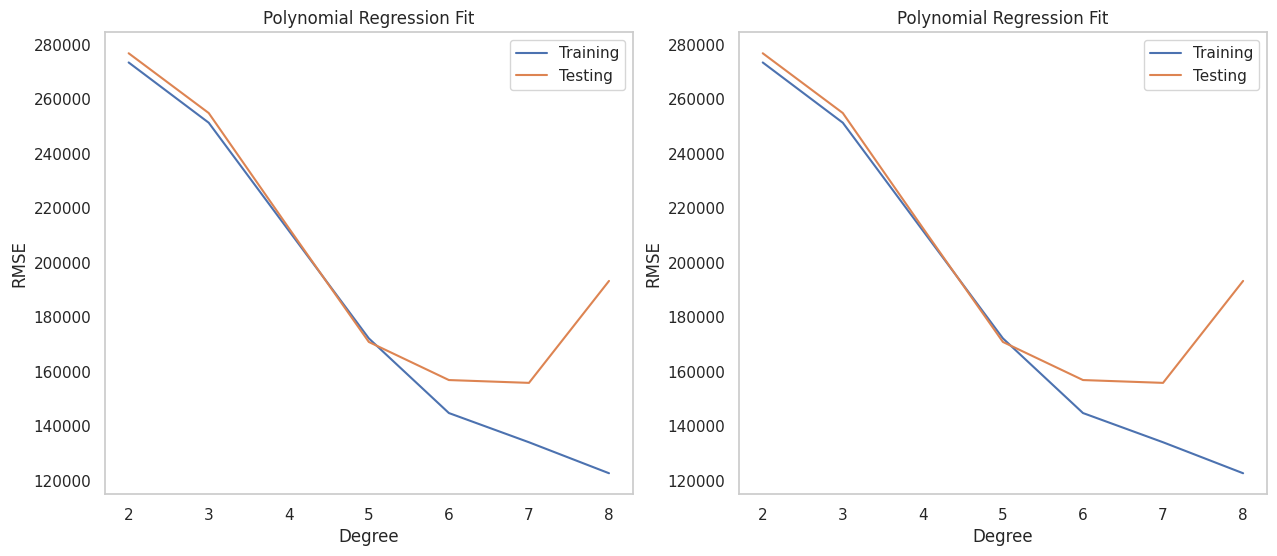

In [ ]:
Trr=[]; Tss=[]
n_degree = 9

for i in range(2,n_degree):
    #print(f'{i} Degree')
    poly_reg = PolynomialFeatures(degree=i)
    X_poly = poly_reg.fit_transform(Train_X_std)
    X_poly1 = poly_reg.fit_transform(Test_X_std)
    LR = LinearRegression()
    LR.fit(X_poly, Train_Y)

    pred1 = LR.predict(X_poly)
    Trr.append(np.sqrt(mean_squared_error(Train_Y, pred1)))

    pred2 = LR.predict(X_poly1)
    Tss.append(np.sqrt(mean_squared_error(Test_Y, pred2)))

plt.figure(figsize=[15,6])
plt.subplot(1,2,1)
plt.plot(range(2,n_degree),Trr, label='Training')
plt.plot(range(2,n_degree),Tss, label='Testing')
plt.title('Polynomial Regression Fit')
plt.xlabel('Degree')
plt.ylabel('RMSE')
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(2,n_degree),Trr, label='Training')
plt.plot(range(2,n_degree),Tss, label='Testing')
plt.title('Polynomial Regression Fit')
plt.xlabel('Degree')
plt.ylabel('RMSE')
plt.grid()
plt.legend()
plt.show()

> Esta función evalúa un modelo de regresión, muestra visualizaciones y almacena métricas en un DataFrame. Además, realiza una selección aleatoria de variables para visualizar la relación entre las variables de entrada y las predicciones.

In [ ]:
# Inspirado en: https://github.com/gagandeepsinghkhanuja/Walmart-Sales-Forecasting/tree/master

Model_Evaluation_Comparison_Matrix = pd.DataFrame(np.zeros([5,8]), columns=['Train-R2','Test-R2','Train-RSS','Test-RSS',
                                                                            'Train-MSE','Test-MSE','Train-RMSE','Test-RMSE'])
rc = np.random.choice(Train_X_std.loc[:,Train_X_std.nunique()>=50].columns.values,2)
def Evaluate(n, pred1,pred2):
    plt.figure(figsize=[15,6])
    for e,i in enumerate(rc):
        plt.subplot(2,3,e+1)
        plt.scatter(y=Train_Y, x=Train_X_std[i], label='Actual')
        plt.scatter(y=pred1, x=Train_X_std[i], label='Prediction')
        plt.legend()
    plt.show()


    print('\n\n{}Métricas del conjunto de entrenamiento{}'.format('-'*20, '-'*20))
    print('\nPuntuación R2 del conjunto de entrenamiento --->',round(r2_score(Train_Y, pred1),20))
    print('Suma residual de cuadrados (RSS) en el conjunto de entrenamiento  --->',round(np.sum(np.square(Train_Y-pred1)),20))
    print('Error cuadrático medio (ECM) en el conjunto de entrenamiento       --->',round(mean_squared_error(Train_Y, pred1),20))
    print('Error Cuadrático Medio Raíz (ECMR) en el conjunto de entrenamiento. --->',round(np.sqrt(mean_squared_error(Train_Y, pred1)),20))

    print('\n{}Métricas del conjunto de Prueba{}'.format('-'*20, '-'*20))
    print('\nPuntuación R2 del conjunto de Prueba  --->',round(r2_score(Test_Y, pred2),20))
    print('Suma residual de cuadrados (RSS) en el conjunto de Prueba  --->',round(np.sum(np.square(Test_Y-pred2)),20))
    print('Error cuadrático medio (ECM) en el conjunto de Prueba       --->',round(mean_squared_error(Test_Y, pred2),20))
    print('Error Cuadrático Medio Raíz (ECMR) en el conjunto de Prueba. --->',round(np.sqrt(mean_squared_error(Test_Y, pred2)),20))
    print('\n{}Residual Plots{}'.format('-'*20, '-'*20))

    Model_Evaluation_Comparison_Matrix.loc[n,'Train-R2']  = round(r2_score(Train_Y, pred1),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-R2']   = round(r2_score(Test_Y, pred2),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-RSS'] = round(np.sum(np.square(Train_Y-pred1)),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-RSS']  = round(np.sum(np.square(Test_Y-pred2)),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-MSE'] = round(mean_squared_error(Train_Y, pred1),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-MSE']  = round(mean_squared_error(Test_Y, pred2),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-RMSE']= round(np.sqrt(mean_squared_error(Train_Y, pred1)),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-RMSE'] = round(np.sqrt(mean_squared_error(Test_Y, pred2)),20)

    plt.figure(figsize=[15,4])

    plt.subplot(1,2,1)
    sns.distplot((Train_Y - pred1))
    plt.title('Error Terms')
    plt.xlabel('Errors')

    plt.subplot(1,2,2)
    plt.scatter(Train_Y,pred1)
    plt.plot([Train_Y.min(),Train_Y.max()],[Train_Y.min(),Train_Y.max()], 'r--')
    plt.title('Test vs Prediction')
    plt.xlabel('y_test')
    plt.ylabel('y_pred')
    plt.show()

> Evaluamos el modelo de regresión polinómica

In [ ]:
MLR = LinearRegression().fit(Train_X_std,Train_Y)
poly_reg = PolynomialFeatures(degree=2)
X_poly = poly_reg.fit_transform(Train_X_std)
X_poly1 = poly_reg.fit_transform(Test_X_std)
PR = LinearRegression()
PR.fit(X_poly, Train_Y)

pred1 = PR.predict(X_poly)
pred2 = PR.predict(X_poly1)

print('{}{}\033[1m Evaluación del modelo de regresión polinómica \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
print('El coeficiente del modelo de regresión resultó ser ',MLR.coef_)
print('La intercepción del modelo de regresión es ',MLR.intercept_)


<<<----------------------------------- Evaluación del modelo de regresión polinómica ----------------------------------->>>

El coeficiente del modelo de regresión resultó ser  [-94143.59491379 434762.81107512 -59493.00929766  13624.11767673
  -6606.04958164]
La intercepción del modelo de regresión es  1050932.3860975136


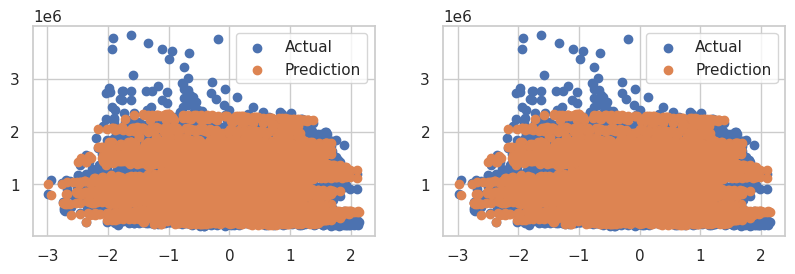



--------------------Métricas del conjunto de entrenamiento--------------------

Puntuación R2 del conjunto de entrenamiento ---> 0.7642650773088626
Suma residual de cuadrados (RSS) en el conjunto de entrenamiento  ---> 384905273505512.8
Error cuadrático medio (ECM) en el conjunto de entrenamiento       ---> 74767924146.37001
Error Cuadrático Medio Raíz (ECMR) en el conjunto de entrenamiento. ---> 273437.2398675243

--------------------Métricas del conjunto de Prueba--------------------

Puntuación R2 del conjunto de Prueba  ---> 0.7630037476981689
Suma residual de cuadrados (RSS) en el conjunto de Prueba  ---> 98620934278994.94
Error cuadrático medio (ECM) en el conjunto de Prueba       ---> 76628542563.32162
Error Cuadrático Medio Raíz (ECMR) en el conjunto de Prueba. ---> 276818.60949604097

--------------------Residual Plots--------------------


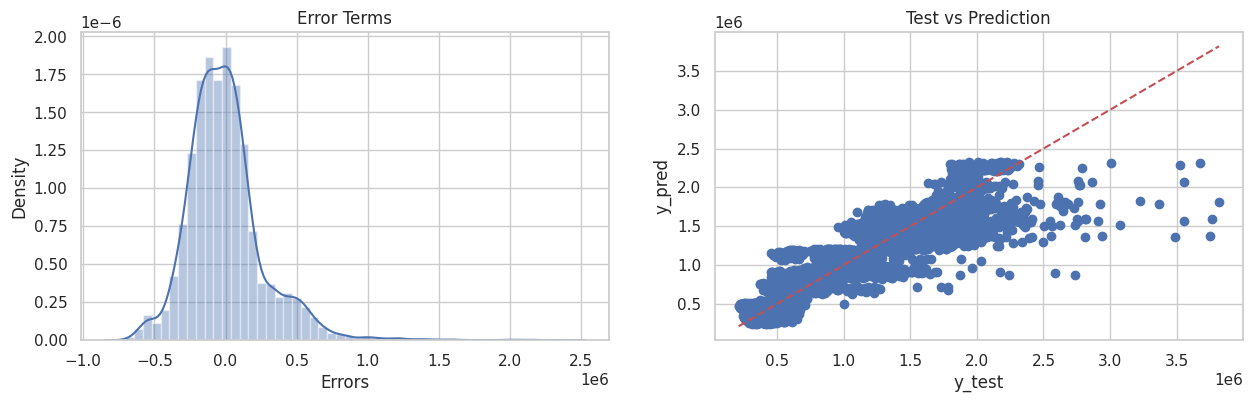

In [ ]:
Evaluate(5, pred1, pred2)

> ## **Analisis Con Series de Tiempo**
>
> Exploraremos minuciosamente una de las tiendas mediante un análisis detallado de series temporales. Este análisis implica examinar datos registrados a intervalos fijos de tiempo, como las ventas semanales, para comprender cómo el tiempo afecta las variables dependientes. Previo a este análisis, se realizará una evaluación de estacionariedad, eliminando tendencias y estacionalidades de la serie temporal para garantizar la precisión en la interpretación y pronóstico de los datos.

In [ ]:
data1 = pd.read_csv('train.csv')
data1.set_index('Date', inplace=True)

store1 = data1[data1.Store == 1]

sales1 = pd.DataFrame(store1.Weekly_Sales.groupby(store1.index).sum())
sales1.dtypes


sales1.reset_index(inplace = True)

sales1['Date'] = pd.to_datetime(sales1['Date'])

sales1.set_index('Date',inplace = True)

sales1.head()

,Weekly_Sales
Date,
2010-02-05,1643690.90
2010-02-12,1641957.44
2010-02-19,1611968.17
2010-02-26,1409727.59
2010-03-05,1554806.68


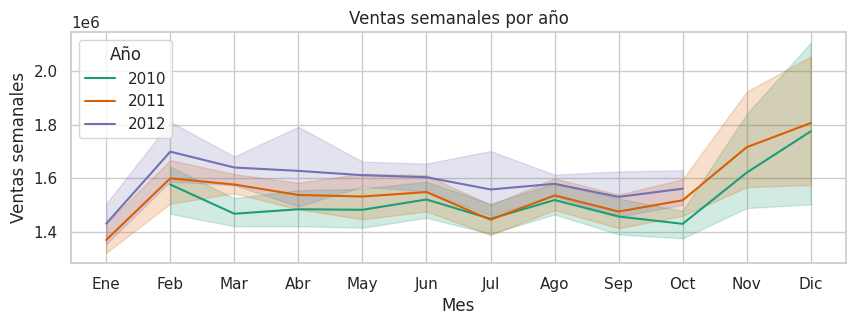

In [ ]:
year_df =  sales1[(sales1.index.year == 2011) | (sales1.index.year == 2012) | (sales1.index.year == 2010)]

plt.figure(figsize=(10, 3))
sns.lineplot(data=year_df, x=year_df.index.month, y='Weekly_Sales', hue=year_df.index.year, palette='Dark2')

plt.title('Ventas semanales por año')
plt.xlabel('Mes')
plt.ylabel('Ventas semanales')
plt.xticks(range(1, 13), ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'])
plt.legend(title='Año')
plt.grid(True)
plt.show()

Podemos ver que el comportamiento de las ventas es bastante similar cada año, con un mayor número de ventas en febero y de octubre a diciembre. Además, nos muestra que el volumen de ventas está aumentando cada año.

Siguiendo el esquema anterior, en este paso utilizamos herramientas para identificar las características de la serie temporal, de modo que podamos construir un modelo adecuado.

Aquí buscamos respuestas a preguntas como:

    ¿La serie temporal es estacionaria?

    Si no es estacionaria, ¿qué transformación debemos aplicar para hacerla estacionaria?

    ¿La serie temporal tiene estacionalidad?

    Si hay estacionalidad, ¿cuál es el período estacional?

    ¿Qué órdenes debemos usar? (p para AR, q para MA)

Ahora graficaremos la serie temporal completa

<Figure size 1800x600 with 0 Axes>

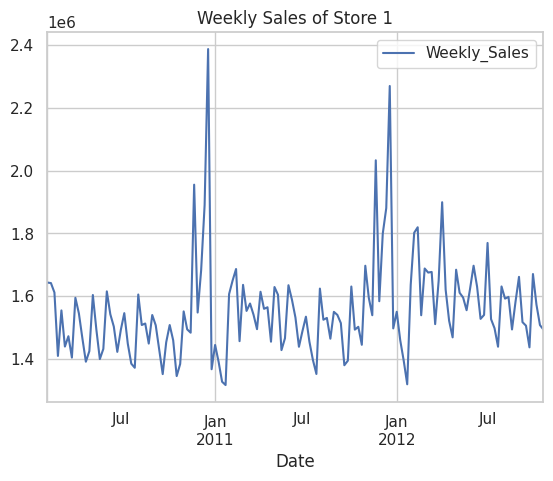

In [ ]:
plt.figure(figsize=(18, 6))
sales1.plot()
plt.title('Weekly Sales of Store 1');

### Evaluación de estacionariedad

> Identificación de patrones estacionales

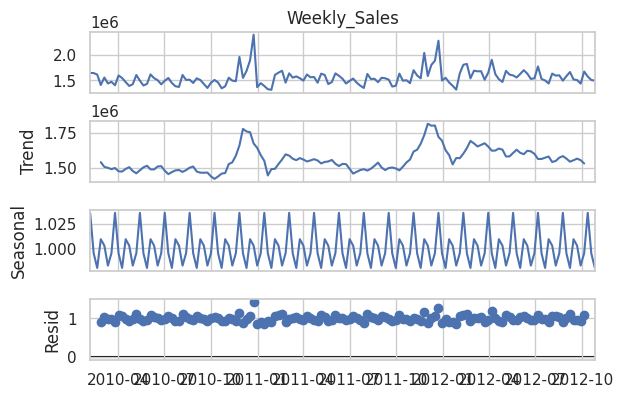

In [ ]:
import statsmodels.api as sm
seas_d=sm.tsa.seasonal_decompose(sales1['Weekly_Sales'],model='multiplicative',period=7);
fig=seas_d.plot()
fig.set_figheight(4)
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries, significance_level=0.05):

    """
    Realiza la prueba de Dickey-Fuller Aumentada en una serie de tiempo dada y evalúa su estacionariedad.

    Parámetros:
    time_series (array-like): Los datos de la serie de tiempo a ser probados.
    significance_level (float): El nivel de significancia para la prueba (por defecto es 0.05).

    retorna:
    dict: Un diccionario que contiene el estadístico ADF, el valor p, los valores críticos y si la serie es estacionaria.

    """
    dftest = adfuller(timeseries)
    adf_statistic, p_value, used_lag, nobs, critical_values, icbest = dftest

    # Determinar si la serie es estacionaria basado en el valor p y el estadístico ADF
    is_stationary_p = p_value < significance_level
    is_stationary_adf = adf_statistic < critical_values['5%']  # Utiliza el valor crítico al 5%
    is_stationary = is_stationary_p and is_stationary_adf

    return {
        "ADF Statistic": adf_statistic,
        "p-value": p_value,
        "Critical Values": critical_values,
        "Is Stationary (p-value)": is_stationary_p,
        "Is Stationary (ADF)": is_stationary_adf,
        "Is Stationary (Both)": is_stationary
    }



adf_test_results = test_stationarity(sales1)
adf_test_results

{'ADF Statistic': -5.102186145192287,
 'p-value': 1.3877788330759535e-05,
 'Critical Values': {'1%': -3.47864788917503,
  '5%': -2.882721765644168,
  '10%': -2.578065326612056},
 'Is Stationary (p-value)': True,
 'Is Stationary (ADF)': True,
 'Is Stationary (Both)': True}

> Con base en en las graficas y los resultados obtenidos de la prueba de Dickey-Fuller Aumentada (ADF), donde el estadístico ADF es -5.1022 y el valor p es 1.39e-05, se llega a la conclusión de que la serie es estacionaria. Esta afirmación se respalda al observar que el estadístico ADF es significativamente menor que los valores críticos al 1%, 5%, y 10%. Este hallazgo permite proceder con mayor confianza a la aplicación de modelos de pronóstico y técnicas de análisis de series temporales que asumen estacionariedad.

### Prueba de autocorrelación (ACF) y autocorrelacion parcial (PACF)

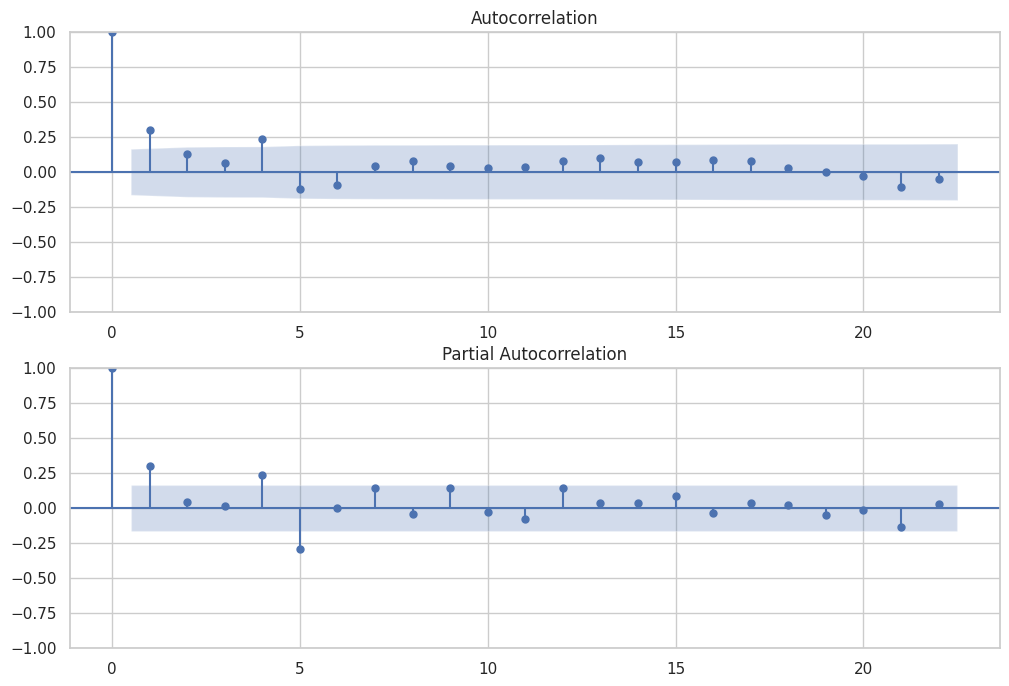

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))

plot_acf(sales1.dropna(),ax=ax1)

# Plot the PACF of df_store_2_item_28_timeon ax2
plot_pacf(sales1.dropna(), ax=ax2)

plt.show()

Ahora optaremos por un enfoque de exploración y experimentación para seleccionar el modelo ARIMA o SARIMA más adecuado. Probaremos diferentes combinaciones de términos ARIMA y SARIMA, evaluando su rendimiento mediante métricas.

La experimentación con modelos ajustando manualmente los parámetros y evaluando el rendimiento en un conjunto de datos de validación será esencial para tomar decisiones informadas sobre la estructura del modelo que mejor se adapte a la complejidad de la serie temporal en cuestión. Este enfoque iterativo nos permitirá seleccionar un modelo que capture de manera efectiva la dinámica subyacente de los datos, incluso en ausencia de patrones estacionales evidentes en las gráficas iniciales.


### Modelo Arima

In [ ]:
train_size = 100
assert train_size < len(sales1), "El tamaño de entrenamiento debe ser menor que el número total de filas en el DataFrame"

train_st = sales1[:train_size]
test_st = sales1[train_size:]

len(train_st), len(test_st)

(100, 43)

> Las gráficas de ACF y PACF pueden ayudarnos a encontrar valores adecuados para los parámetros p y q. Sin embargo, la interpretación de estas gráficas no siempre es clara. Para obtener más seguridad en nuestras elecciones, podemos aplicar un método empírico. Este método consiste en ajustar el modelo ARIMA para diferentes valores de p y q, y elegir el mejor valor según métricas.

In [ ]:
from typing import Union
from tqdm import tqdm_notebook
from itertools import product

from statsmodels.tsa.arima.model import ARIMA

def optimize_ARIMA(endog: Union[pd.Series, list], order_list: list, d: int) -> pd.DataFrame:

    results = []

    for order in tqdm_notebook(order_list):
        try:
            model = ARIMA(endog, order=(order[0], d, order[1])).fit()
        except:
            continue

        aic = model.aic
        results.append([order, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df


In [ ]:
ps =[1,4,5]
qs =[1,4]
d = 0

order_list = list(product(ps, qs))

result_df = optimize_ARIMA(train_st, order_list, d)
print(result_df)

  0%|          | 0/6 [00:00<?, ?it/s]

    (p,q)          AIC
0  (1, 4)  2675.024056
1  (4, 4)  2679.705638
2  (5, 1)  2680.838261
3  (5, 4)  2680.861893
4  (4, 1)  2684.008758
5  (1, 1)  2688.564935


Los mejores valores para p y q son 1 y 4 respectivamente.

#### Evaluar modelo ARIMA

                               SARIMAX Results                                
Dep. Variable:           Weekly_Sales   No. Observations:                  100
Model:                 ARIMA(1, 0, 4)   Log Likelihood               -1330.512
Date:                Sat, 02 Dec 2023   AIC                           2675.024
Time:                        01:57:56   BIC                           2693.260
Sample:                    02-05-2010   HQIC                          2682.405
                         - 12-30-2011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.542e+06   3.89e+04     39.648      0.000    1.47e+06    1.62e+06
ar.L1         -0.1085      0.204     -0.532      0.594      -0.508       0.291
ma.L1          0.4695      0.201      2.331      0.0

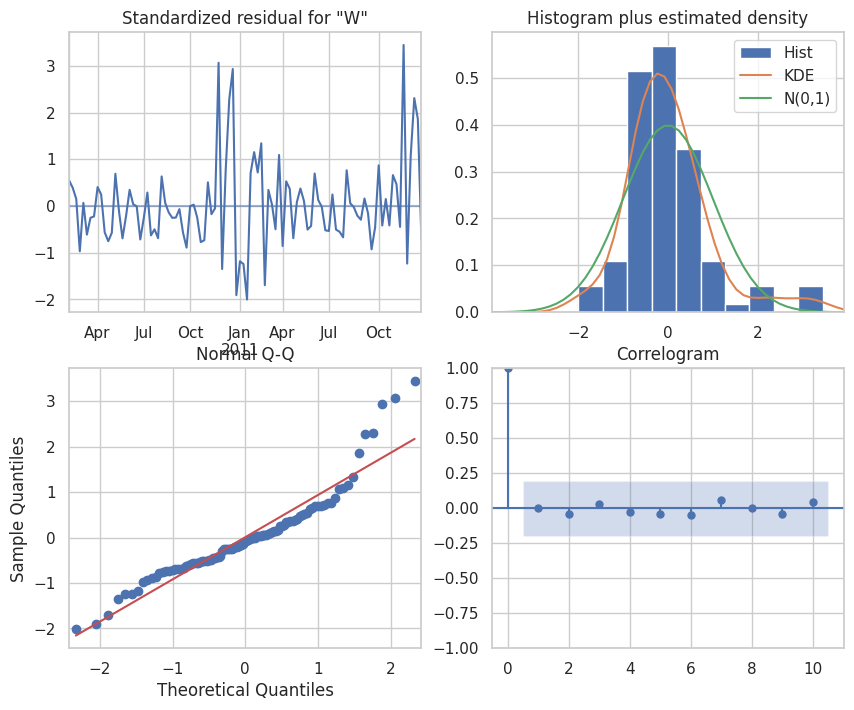

In [ ]:
model = ARIMA(train_st, order=(1, 0, 4))
results = model.fit()

print(results.summary())
results.plot_diagnostics(figsize=(10,8));

En la evaluación de nuestro modelo, hemos observado varios aspectos clave para determinar su calidad. Idealmente, los residuos de un modelo deberían comportarse como ruido blanco gaussiano no correlacionado centrado en cero. Sin embargo, al analizar detenidamente los gráficos resultantes (en sentido horario desde el gráfico superior izquierdo), hemos identificado algunas observaciones importantes:

1. Residuo Estandarizado: Se ha observado un patrón repetitivo anual en los residuos estandarizados. Este patrón podría indicar la presencia de estacionalidad no capturada por el modelo actual, sugiriendo la posibilidad de que un modelo SARIMA pueda ser más apropiado.

2. Histograma más Estimación de Densidad de Kernel (KDE): Aunque el histograma exhibe una distribución medida de los residuos, la curva KDE muestra una distribución normal. Sin embargo, la similitud entre la curva naranja y la verde podría mejorarse para garantizar una concordancia más cercana, lo que sugiere áreas de mejora en la precisión del modelo.

3. Correlograma o Gráfico ACF: La ausencia de correlaciones significativas para rezagos mayores que uno indica que el modelo ha capturado adecuadamente las relaciones de dependencia temporal, respaldando la calidad del modelo en este aspecto.

4. Gráfico Normal Q-Q: La mayoría de los puntos de datos que se encuentran en la línea recta indican una distribución normal de los residuos, reflejando un aspecto positivo en la calidad del modelo en este aspecto.

En conclusión, a pesar de algunos patrones observados en los residuos estandarizados y posibles mejoras en la similitud entre las curvas en el histograma, el modelo actual parece tener buenos indicadores en términos de correlación temporal y distribución normal de los residuos. Sin embargo, se sugiere una consideración adicional, especialmente en relación con la estacionalidad evidente, para determinar si la transición a un modelo SARIMA podría ofrecer una mejora significativa.


#### Rolling forecast

In [ ]:
def rolling_forecast(df, train_len, horizon: int, window: int, order: list):

    total_len = train_len + horizon
    pred_ARIMA = []
    pred_ARIMA_2 = []

    for i in tqdm_notebook(range(train_len, total_len, window)):
        model = ARIMA(df[:i], order=order)
        res = model.fit()
        predictions = res.forecast(window)
        pred_ARIMA.extend(predictions)

    return pred_ARIMA

In [ ]:
import numpy as np
TRAIN_LEN = len(train_st)
HORIZON = len(test_st)
WINDOW = 8
pred_ARIMA_st = rolling_forecast(sales1, TRAIN_LEN, HORIZON, WINDOW, (1,0,4))
fechas = test_st.index
st_pred_ARIMA_st = pd.Series(pred_ARIMA_st[:len(fechas)], index=fechas)

mse = mean_squared_error(test_st, st_pred_ARIMA_st)
rmse = np.sqrt(mse)

mse, rmse

  0%|          | 0/6 [00:00<?, ?it/s]

(15100100959.130621, 122882.46807063496)

(15100100959.130621, 122882.46807063496)

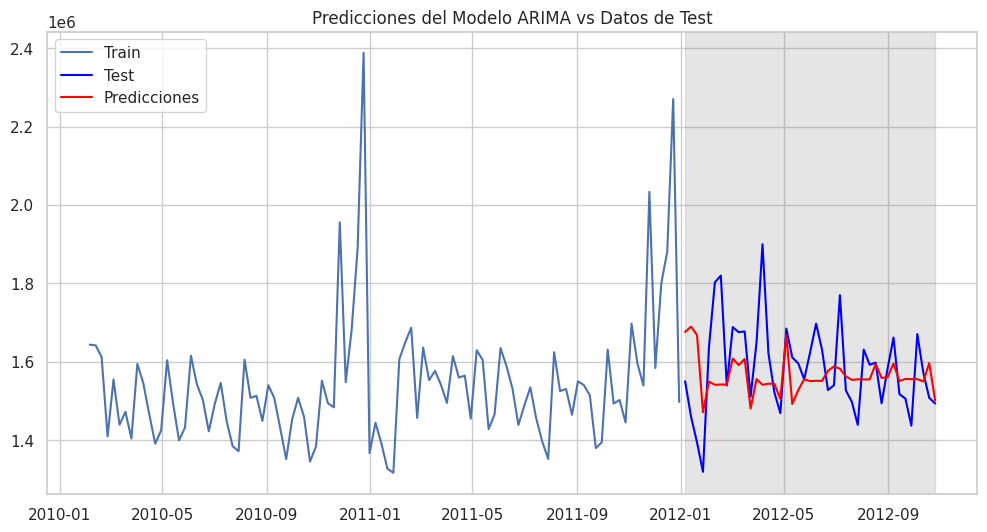

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(train_st,label='Train')
ax.plot(test_st, label='Test', color='blue')
ax.plot(st_pred_ARIMA_st, label='Predicciones', color='red')
ax.legend(loc='best')
ax.set_title('Predicciones del Modelo ARIMA vs Datos de Test')


fecha_inicio = test_st.index[0]
fecha_fin = test_st.index[-1]
ax.axvspan(fecha_inicio, fecha_fin, color='#808080', alpha=0.2)


mse = mean_squared_error(test_st, st_pred_ARIMA_st)
rmse = np.sqrt(mse)

mse, rmse

In [ ]:
y_true = test_st['Weekly_Sales'].values
y_pred = st_pred_ARIMA_st.values

mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f"MAPE: {mape:.2f}%")

MAPE: 5.73%


Después de calcular el Error Cuadrático Medio (MSE) y la Raíz del Error Cuadrático Medio (RMSE) para el modelo ARIMA y al visualizar la comparación gráfica entre las predicciones del modelo ARIMA y los valores reales mediante el test, se observa cierta similitud, aunque no tan consistente como se esperaba. A pesar de su rendimiento en términos de MSE y RMSE, el modelo ARIMA parece no capturar completamente las complejidades subyacentes de los datos, como se refleja en los patrones en los residuos estandarizados. Además, teniendo en cuenta que el MAPE es del 5.73%, indicando un nivel razonablemente bajo de error porcentual absoluto medio en las predicciones, exploraremos ahora la implementación de un modelo SARIMA para abordar más efectivamente estos aspectos específicos tratando de mejorar aún más la capacidad predictiva, considerando la posibilidad de lograr una mayor precisión en las predicciones.

### Modelo SARIMA

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def optimize_SARIMA(endog: Union[pd.Series, list], order_list: list, d: int, D: int, m: int) -> pd.DataFrame:

    results = []

    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(
                endog,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], m),
                simple_differencing=False).fit(disp=False)
        except:
            continue

        aic = model.aic
        results.append([order, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

In [ ]:
ps =[0,1,4,5]
qs =[0,1,4]
Ps = [0,1,4,5]
Qs = [0,1,4]

SARIMA_order_list = list(product(ps, qs, Ps, Qs))

d = 0
D = 1
m = 26

SARIMA_result_df = optimize_SARIMA(train_st, SARIMA_order_list, d, D, m)
SARIMA_result_df

  0%|          | 0/144 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(1, 1, 1, 0)",2030.237941
1,"(4, 0, 1, 0)",2030.604227
2,"(1, 1, 1, 1)",2031.479562
3,"(5, 0, 1, 0)",2031.644558
4,"(4, 0, 1, 1)",2031.737117
...,...,...
139,"(0, 0, 4, 4)",2060.253473
140,"(0, 0, 5, 4)",2062.253471
141,"(5, 4, 4, 4)",2063.770467
142,"(5, 4, 5, 4)",2065.851967


                                      SARIMAX Results                                      
Dep. Variable:                        Weekly_Sales   No. Observations:                  100
Model:             SARIMAX(1, 0, 1)x(1, 1, [], 26)   Log Likelihood               -1011.119
Date:                             Sat, 02 Dec 2023   AIC                           2030.238
Time:                                     03:12:19   BIC                           2039.454
Sample:                                 02-05-2010   HQIC                          2033.914
                                      - 12-30-2011                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9282      0.025     37.025      0.000       0.879       0.977
ma.L1         -0.3866      

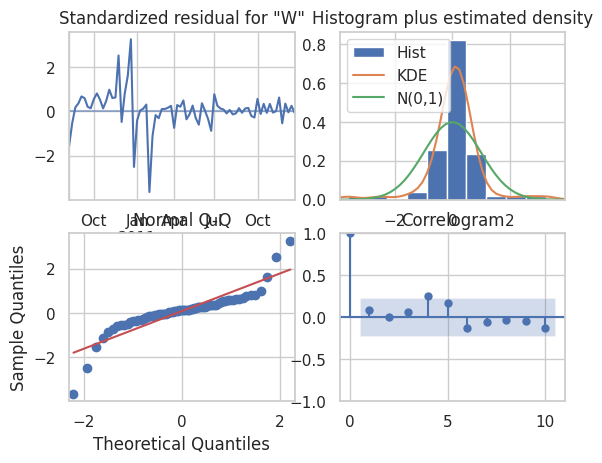

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

SARIMA_model = SARIMAX(train_st, order=(1,0,1), seasonal_order=(1,1,0,26))
SARIMA_model_fit = SARIMA_model.fit(disp=False)

print(SARIMA_model_fit.summary())

SARIMA_model_fit.plot_diagnostics();

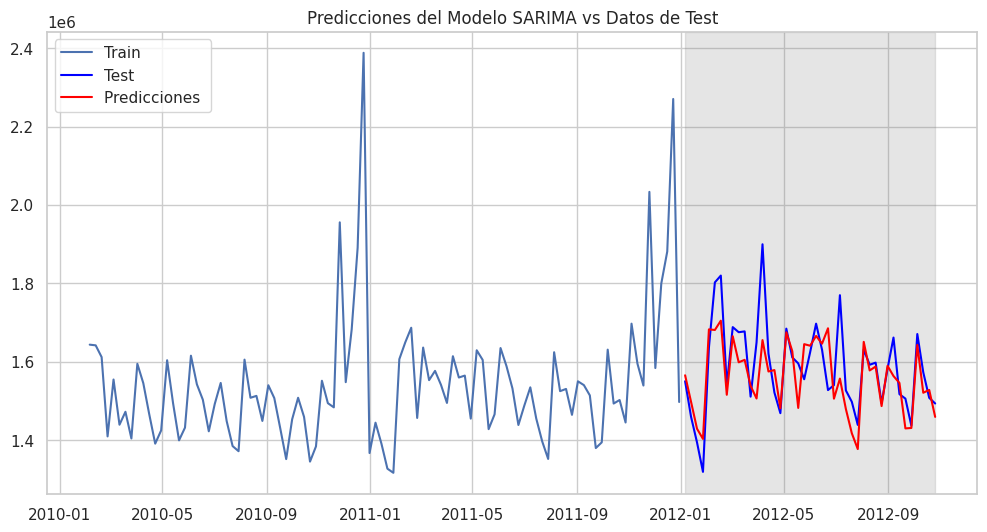

In [79]:
SARIMA_pred = SARIMA_model_fit.get_prediction(start=100, end=142).predicted_mean

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(train_st,label='Train')
ax.plot(test_st, label='Test', color='blue')
ax.plot(SARIMA_pred, label='Predicciones ', color='red')
ax.legend(loc='best')
ax.set_title('Predicciones del Modelo SARIMA vs Datos de Test')


fecha_inicio = test_st.index[0]
fecha_fin = test_st.index[-1]
ax.axvspan(fecha_inicio, fecha_fin, color='#808080', alpha=0.2)

In [80]:
mse = mean_squared_error(test_st, SARIMA_pred)
rmse = np.sqrt(mse)

mse, rmse

(6218787321.154993, 78859.28810961328)

In [81]:
y_true = test_st['Weekly_Sales'].values
y_pred = SARIMA_pred.values

mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f"MAPE: {mape:.2f}%")

MAPE: 3.54%
